In [5]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import time
import pendulum
from PIL import Image
import pickle

from ipywidgets import IntProgress
from IPython.display import display, clear_output
import IPython

try:
  import google.colab
  from google.colab import drive, files
  runnin_in_colab = True
except:
  runnin_in_colab = False

import warnings
warnings.filterwarnings('ignore')

pd.set_option("display.max_columns", None)

In [6]:
xls_dir="UT_Smoking_Data"
pickles_dir="UT_Smoking_Data_pickles"
x_dir="UT_Smoking_Data_x"
categ_colname='Class_label'
ts_field='timestamp_WD' 

In [15]:
#rewrite xlsx files into pickles with only acclero data (+human readable timestamps) + classes
#grab 'em hire owerwise https://drive.google.com/file/d/1SWNHKtcx0aJnRPbf-zT5CJb46ERRIvgr/view?usp=share_link
 
make_pickles=False

def static_vars(**kwargs):
    def decorate(func):
        for k in kwargs:
            setattr(func, k, kwargs[k])
        return func
    return decorate

@static_vars(pred_val=-1.0)
def to_ts(x):
  try:
    f_msecs=float(str(x))
    to_ts.pred_val=f_msecs
  except:
    f_msecs=to_ts.pred_val
    print("wrong ts data: {}, reset it to {}".format(str(x), f_msecs))
    
  return pendulum.from_timestamp(f_msecs/1000.0)
                                  
def apply_complex_function(x):                                
  return to_ts(x['timestamp_WD'])

raw_ds_index = {
     0:'timestamp_WD', 
     1:'Accelerometer_x_WD', 
     2:'Accelerometer_y_WD', 
     3:'Accelerometer_z_WD', 
     4:'Linear_acceleration_sensor_x_WD', 
     5:'Linear_acceleration_sensor_y_WD', 
     6:'Linear_acceleration_sensor_z_WD', 
     7:'Gyroscope_x_WD', 
     8:'Gyroscope_y_WD', 
     9:'Gyroscope_z_WD',
    10:'Magnetometer_x_WD', 
    11:'Magnetometer_y_WD', 
    12:'Magnetometer_z_WD', 
    13:'Pressure_sensor_WD', 
    14:'Heart_rate_sensor_WD',
    15:'GAP', 
    16:'sevtimestamp_PD', 
    17:'Accelerometer_x_PD', 
    18:'Accelerometer_y_PD',
    19:'Accelerometer_z_PD',
    20:'Linear_acceleration_sensor_x_PD', 
    21:'Linear_acceleration_sensor_y_PD', 
    22:'Linear_acceleration_sensor_z_PD', 
    23:'Gyroscope_x_PD', 
    24:'Gyroscope_y_PD',
    25:'Gyroscope_z_PD', 
    26:'Magnetometer_x_PD', 
    27:'Magnetometer_y_PD', 
    28:'Magnetometer_z_PD', 
    29:'GPS_lat_PD',
    30:'GPS_long_PD', 
    31:'Class_label'}

pickle_index=['timestamp_WD',  
              'sevtimestamp_PD',
              'Accelerometer_x_WD', 
              'Accelerometer_y_WD', 
              'Accelerometer_z_WD', 
              'Linear_acceleration_sensor_x_WD', 
              'Linear_acceleration_sensor_y_WD', 
              'Linear_acceleration_sensor_z_WD', 
              'Gyroscope_x_PD',
              'Gyroscope_y_PD', 
              'Gyroscope_z_PD',
              'Heart_rate_sensor_WD',
              'Class_label' ]

if make_pickles:
    
    if not os.path.isdir(xls_dir):
        raise("xls dir {} doesnt exist".format(xls_dir))
    
    if not os.path.isdir(pickles_dir):
        print("pickles dir {} doesnt exist, creating it".format(pickles_dir))
        os.mkdir(pickles_dir)
        
    for f_in in os.listdir(xls_dir):  
       
       if not f_in.endswith('.xlsx') : continue 

       f_out=f_in.replace(".xlsx", ".pickle")
       print("processing {} to {}".format(f_in, f_out))

       f_in = os.path.join(xls_dir, f_in)

       print("reading raw {}".format(f_in))
       data = pd.read_excel(f_in, header=None)
       print("got {} rows".format(len(data)))

       try:
         data_rn = data.rename(raw_ds_index, axis=1); del data
         data = data_rn[pickle_index].copy() ; del data_rn
        
         print("start conv msecs ts to dt on...")
         data['datime_WD']=data.apply(apply_complex_function, axis=1)

         f_out=os.path.join(pickles_dir, f_out)
         print("writng pickle {}".format(f_out))
         data.to_pickle(f_out) ;  del data
         
       except Exception as _err: 
         print("failed {} on {}".format(str(_err), f_out))
         pass

In [5]:
#for dataviz only...
participant="Participant2"
data = pd.read_pickle('{}/{}_Data.pickle'.format(pickles_dir, participant))

In [6]:
np.sort(data[categ_colname].unique())

array(['DrinkSD', 'DrinkST', 'Eat', 'Sit', 'SmokeSD', 'SmokeST', 'Stand'],
      dtype=object)

In [18]:
#time.mktime((data.iloc[0].timestamp_WD).timetuple())
data[data[categ_colname] == 'DrinkSD'][997:1005]
len(data[data[categ_colname] == 'DrinkSD'])
#data[data[categ_colname] == 'DrinkSD']['timestamp_WD'].diff().mean()

129200

In [7]:
sampling=50 #sampling rate
win_len=20  #wind size in secs
tot_frame_len=sampling*win_len
act_types=np.sort(data[categ_colname].unique())
n_act_types=len(act_types)

In [52]:
def chk_spl(act_type, sr2chk, df):
  sr=[]
  #chk how clean sampling is...
    
  _sample=df.head(1000)
  _ls=len(_sample)-1
  for idx in range(0, _ls) :
    dts_diff=int(_sample.iloc[idx+1][ts_field]-_sample.iloc[idx][ts_field])
    if dts_diff <=0 : continue
    dts_dif=int(1000/dts_diff)
    if dts_dif > 100 or dts_dif < 1 : continue
    sr.append(dts_dif)
  if len(sr) :  
    sample_found=sum(sr) / len(sr) 
    if sample_found != sr2chk:
      print("approx samping of {} is {}, supposed to be: {}".format(act_type, sample_found, sr2chk))
    else:  
      print("samping of {} is {}".format(act_type, sample_found))
 
#==============

def print_act_ts(f_name, data):    
    fig, axs = plt.subplots(len(act_types), 1, figsize=(12, 16), constrained_layout=True)    
    _n_act=0
    
    for act_type in act_types :        
      act_data = data[(data[categ_colname] == act_type)]; ax = axs[_n_act]
        
      #chk_spl(act_type, sampling, act_data)
      try:
        _n_act+=1
        ax.set_title(act_type)
        ax.set(xlabel='rows in '+f_name, ylabel='timestamps')
        ax.plot(act_data[ts_field])       
      except: 
        print("act {} has no data!".format(act_type))
        ax.axis('off')

def print_act_ts_inv(f_name, data):    
    fig, axs = plt.subplots(len(act_types), 1, figsize=(12, 16), constrained_layout=True)    
    _n_act=0
    
    for act_type in act_types :        
      act_data = data[(data[categ_colname] == act_type)]; ax = axs[_n_act]
        
      #chk_spl(act_type, sampling, act_data)
      try:
        _n_act+=1
        ax.set_title(act_type)
        ax.set(ylabel='rows in '+f_name, xlabel='timestamps')
        ax.plot(act_data['datime_WD'], act_data['Accelerometer_x_WD'])       
      except: 
        print("act {} has no data!".format(act_type))
        ax.axis('off')
        
def print_full_ts(pickles_dir):    
    f_ins=[]
    for f_in in os.listdir(pickles_dir):     
      # load raw from pickle    
      if not (f_in.startswith('Participant') and f_in.endswith('_Data.pickle')) : continue
      f_ins.append(f_in)
    
    fig, axs = plt.subplots(len(f_ins), 1, figsize=(12, 16), constrained_layout=True)
    
    _n_file=0
    for f_in in f_ins:        
      data = pd.read_pickle(os.path.join(pickles_dir, f_in))
      #print("{} {}".format(f_in, len(data))); continue 
        
      ax = axs[_n_file]; 
      try:
        _n_file+=1
        ax.set_title(f_in)
        ax.set(xlabel='rows in '+ f_in, ylabel='timestamps')
        ax.plot(data[ts_field])       
      except Exception as _msg: 
        print("{} file {} has no data !".format(str(_msg), f_in))
        ax.axis('off')

#=============

def print_act_x_acc(f_name, data):    
    fig, axs = plt.subplots(len(act_types), 1, figsize=(12, 16), constrained_layout=True)    
    _n_act=0
    
    for act_type in act_types :        
      act_data = data[(data[categ_colname] == act_type)]; ax = axs[_n_act]
        
      #chk_spl(act_type, sampling, act_data)
      try:
        _n_act+=1
        ax.set_title(act_type)
        ax.set(xlabel='rows in '+f_name, ylabel='x_acc')
        ax.plot(act_data['Accelerometer_x_WD'])       
      except: 
        print("act {} has no data!".format(act_type))
        ax.axis('off')
        
def print_full_x_acc(pickles_dir):    
    f_ins=[]
    for f_in in os.listdir(pickles_dir):     
      # load raw from pickle    
      if not (f_in.startswith('Participant') and f_in.endswith('_Data.pickle')) : continue
      f_ins.append(f_in)
    
    fig, axs = plt.subplots(len(f_ins), 1, figsize=(12, 16), constrained_layout=True)
    
    _n_file=0
    for f_in in f_ins:        
      data = pd.read_pickle(os.path.join(pickles_dir, f_in))
      #print("{} {}".format(f_in, len(data))); continue 
        
      ax = axs[_n_file]; 
      try:
        _n_file+=1
        ax.set_title(f_in)
        ax.set(xlabel='rows in '+ f_in, ylabel='x acc')
        ax.plot(data['Accelerometer_x_WD'])       
      except Exception as _msg: 
        print("{} file {} has no data !".format(str(_msg), f_in))
        ax.axis('off')

        
#clean_act_data(act_type, sampling, act_data)
#continue
#clean_act_data=clean_act_data(act_type, sampling, act_data, sampling, win_len)
#if clean_data :
# clean_data=pd.concat([clean_data, clean_act_data])  
#else : 
# clean_data=clean_act_data.copy()

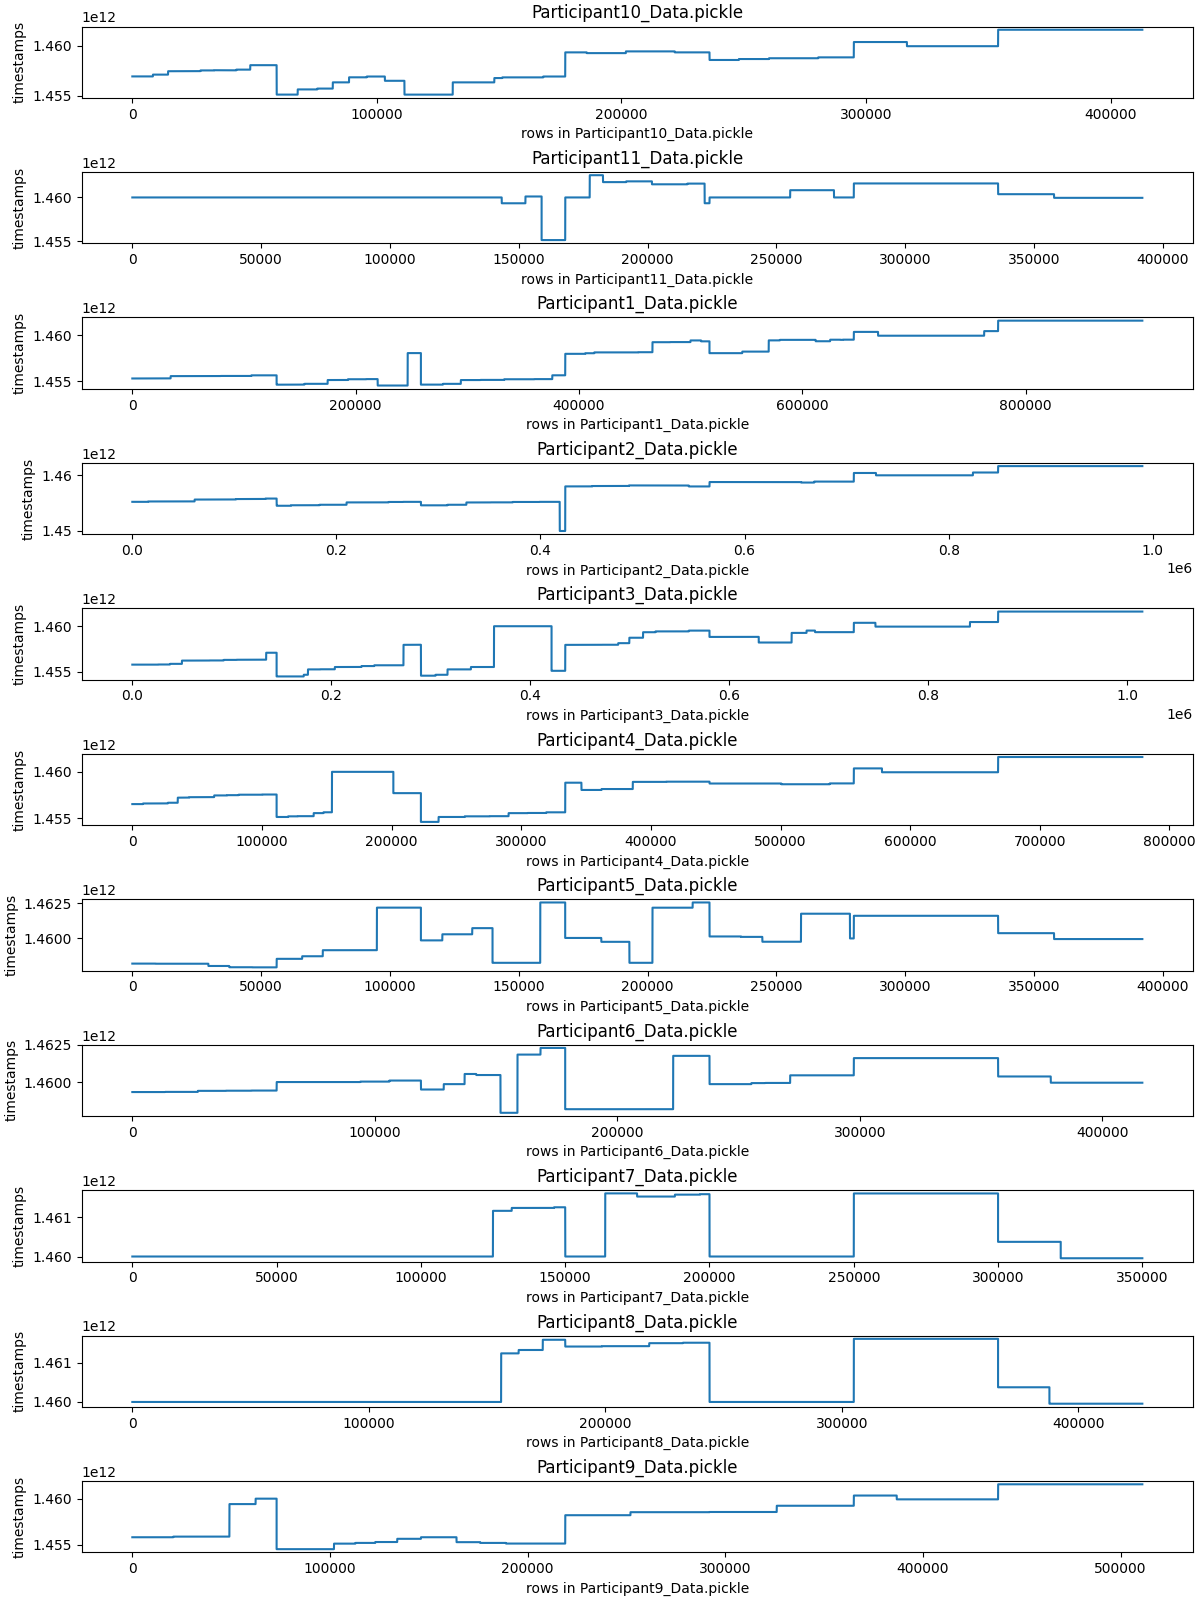

In [26]:
%matplotlib notebook
print_full_ts(pickles_dir)

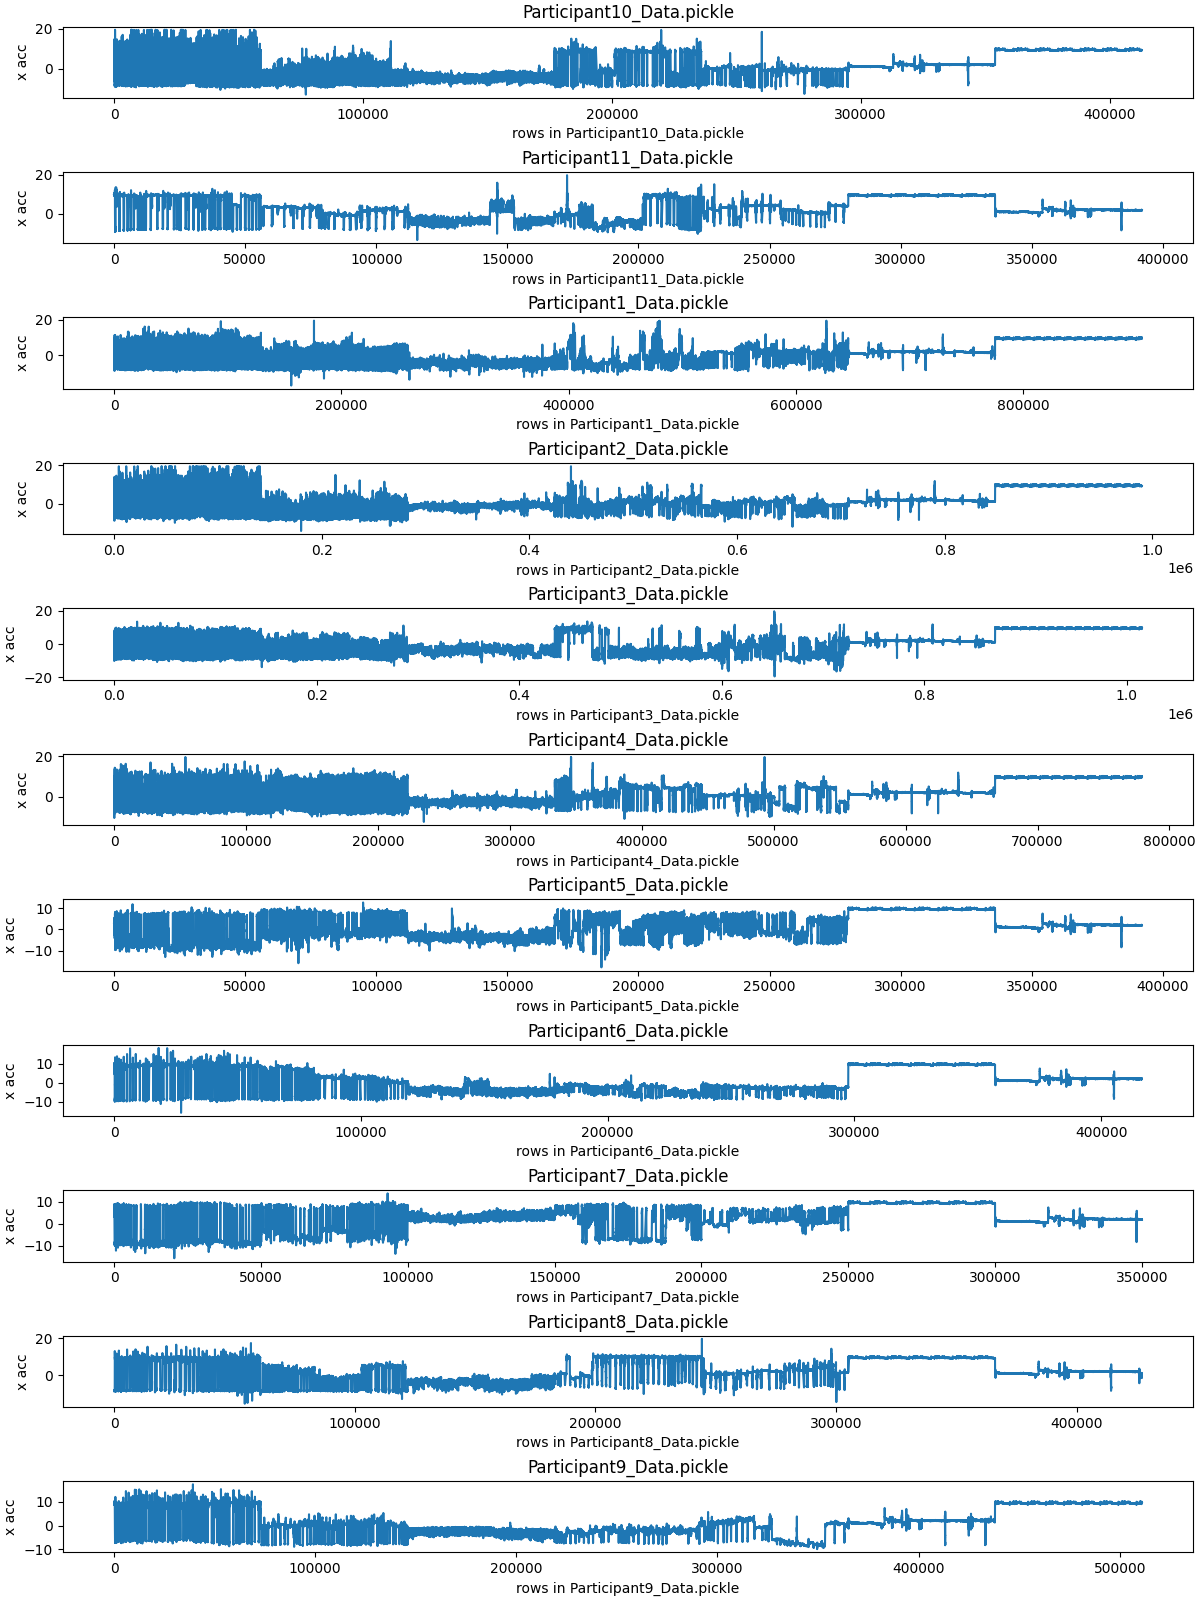

In [39]:
%matplotlib notebook
print_full_x_acc(pickles_dir)

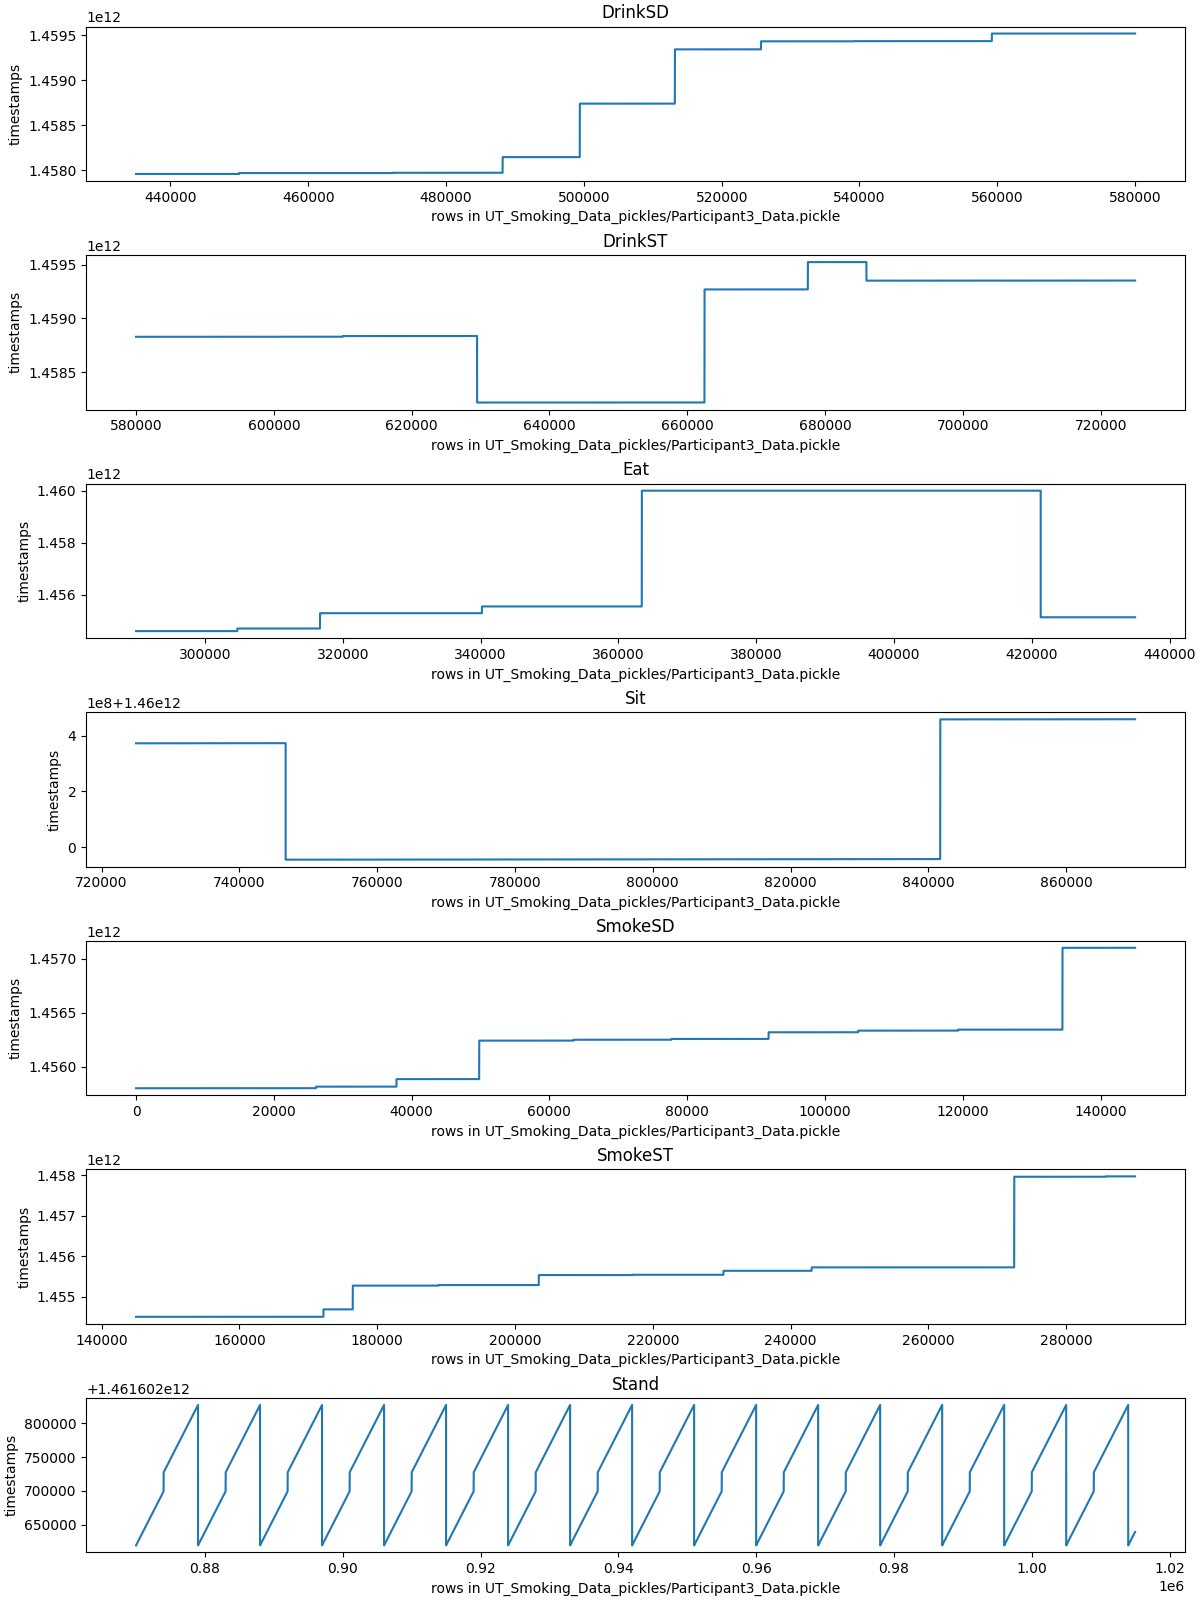

In [65]:
%matplotlib notebook
participant="Participant3"
fname='{}/{}_Data.pickle'.format(pickles_dir, participant)
data = pd.read_pickle(fname)
print_act_ts(fname, data)

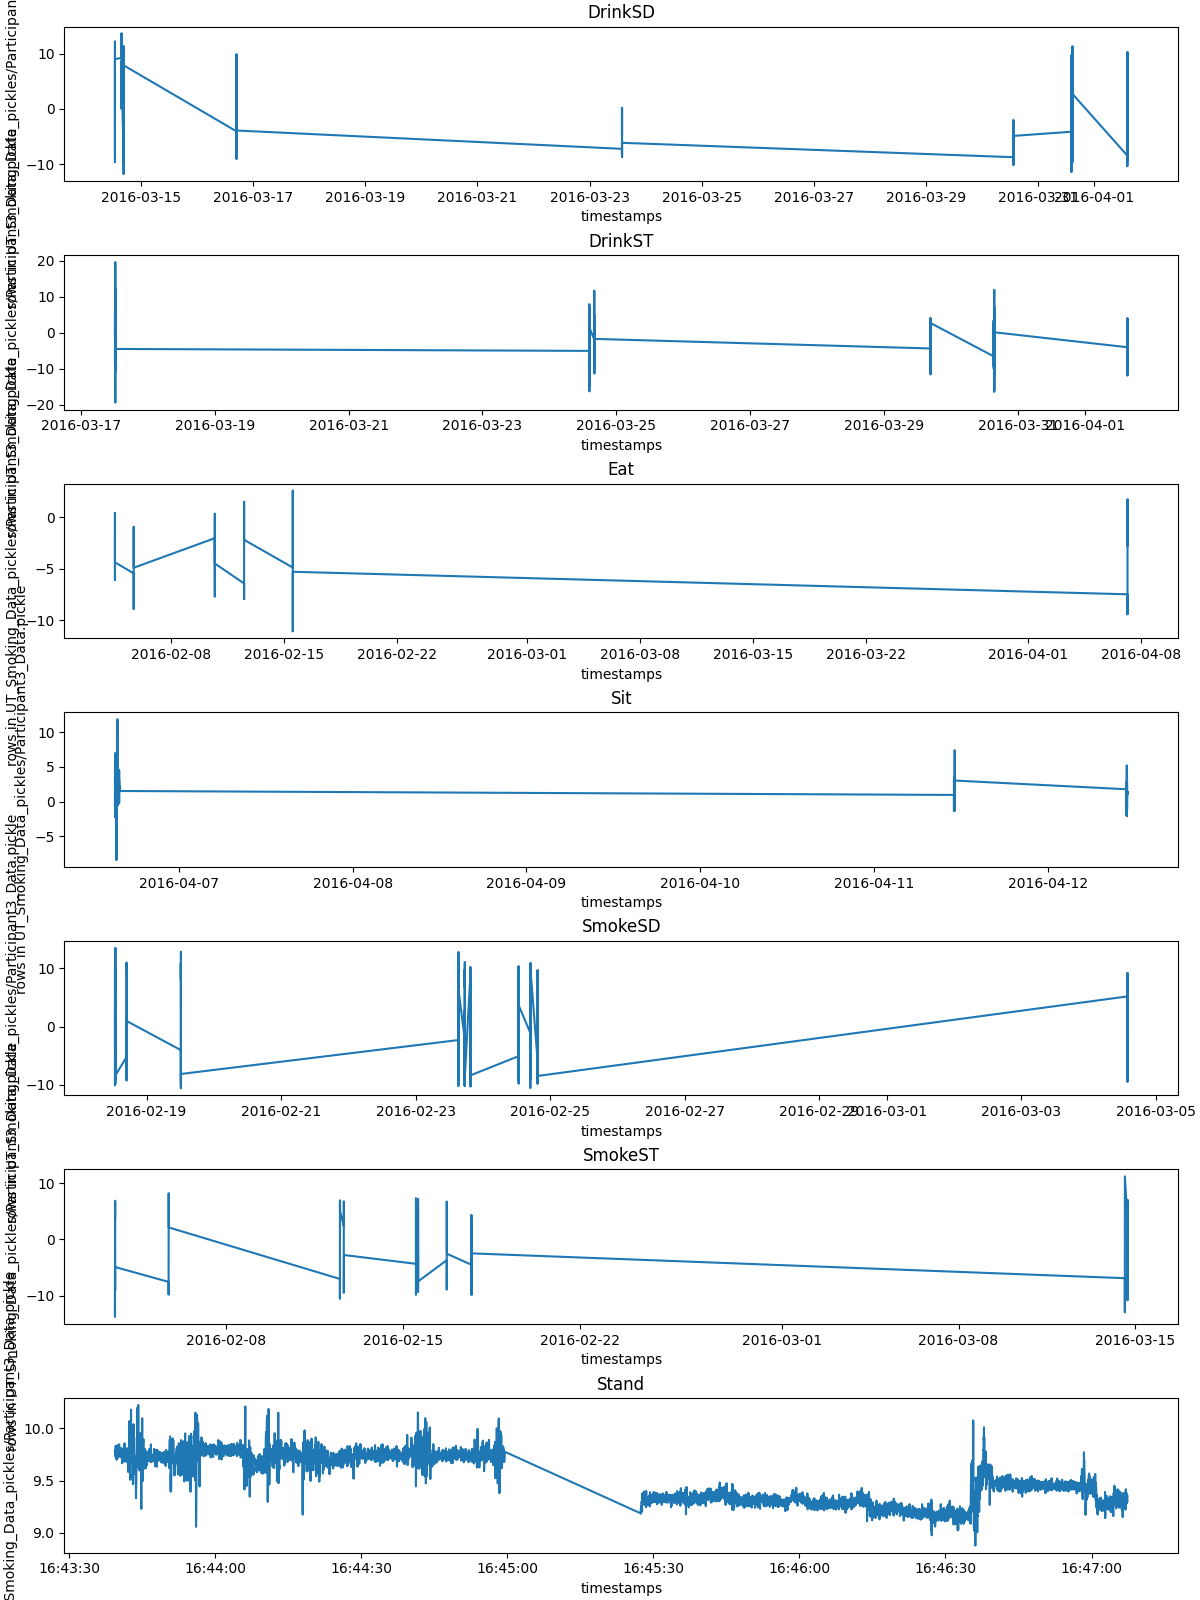

In [67]:
data2=data.sort_values(by=ts_field, ignore_index=True)
data2=data2.reset_index(drop=True)
print_act_ts_inv(fname, data2)

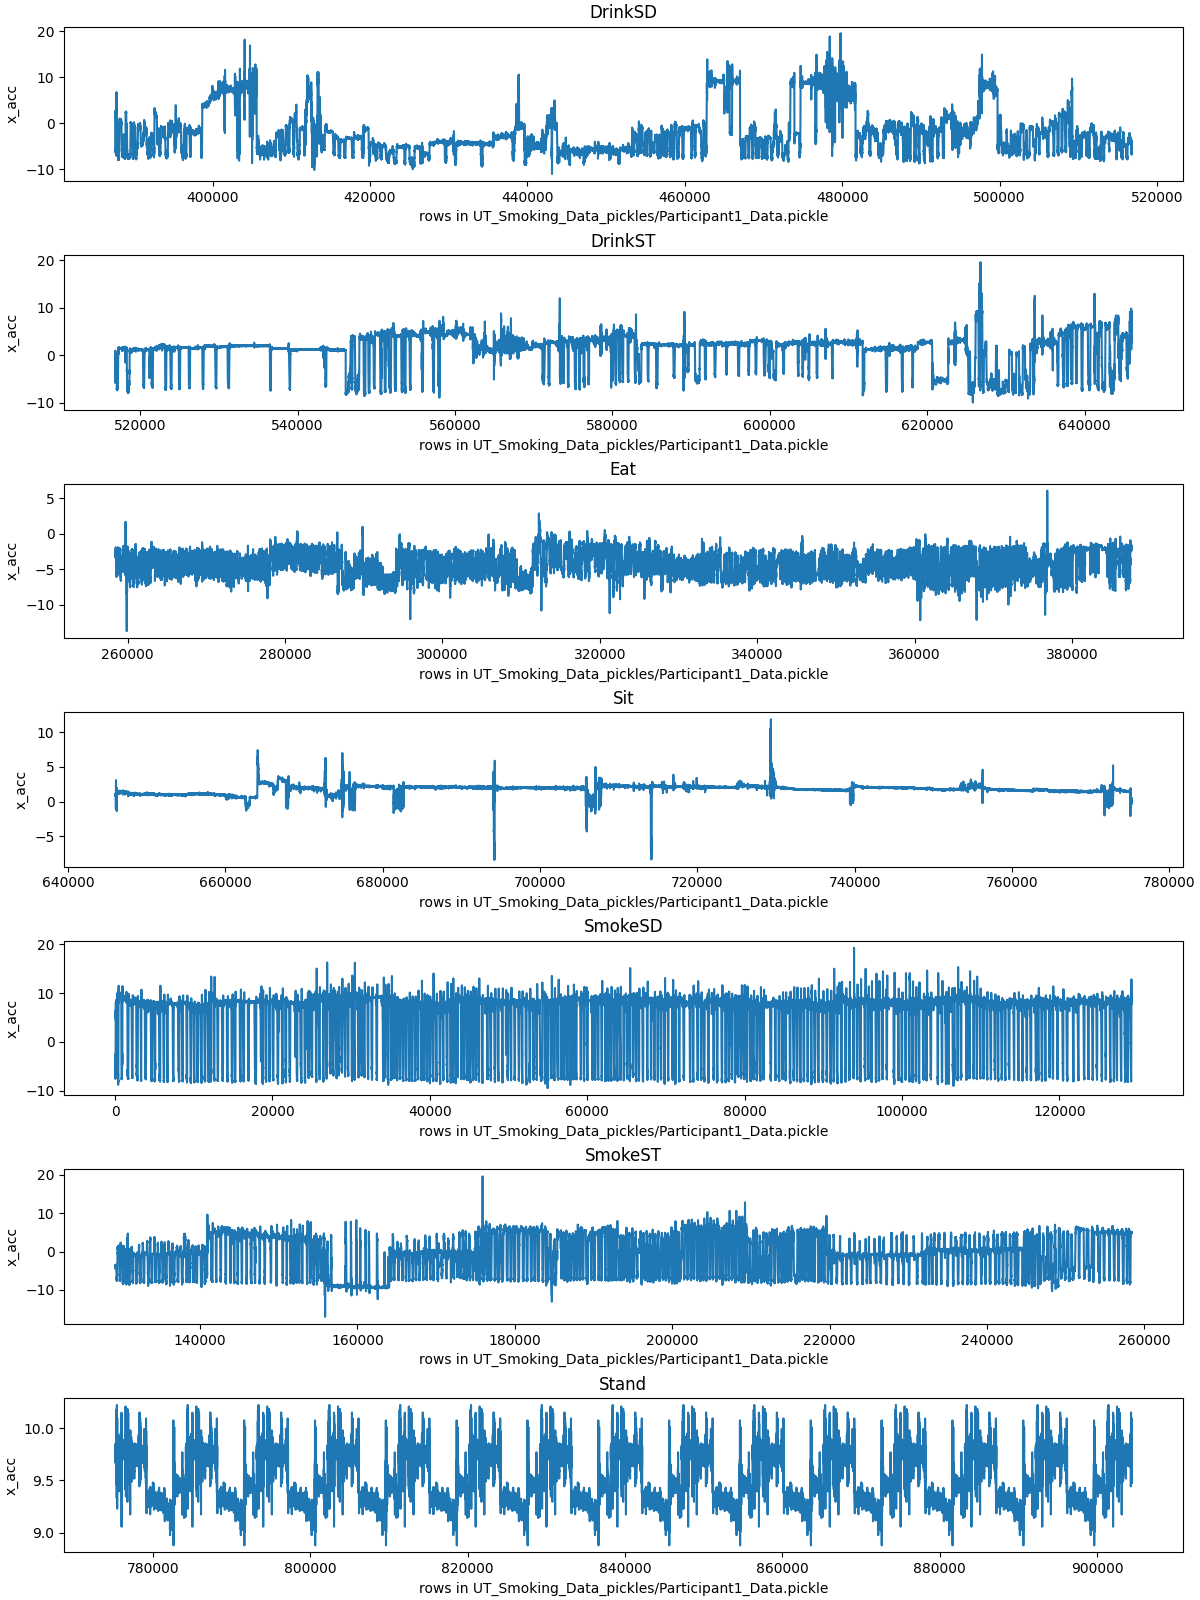

In [34]:
%matplotlib notebook
print_act_x_acc(fname, data)

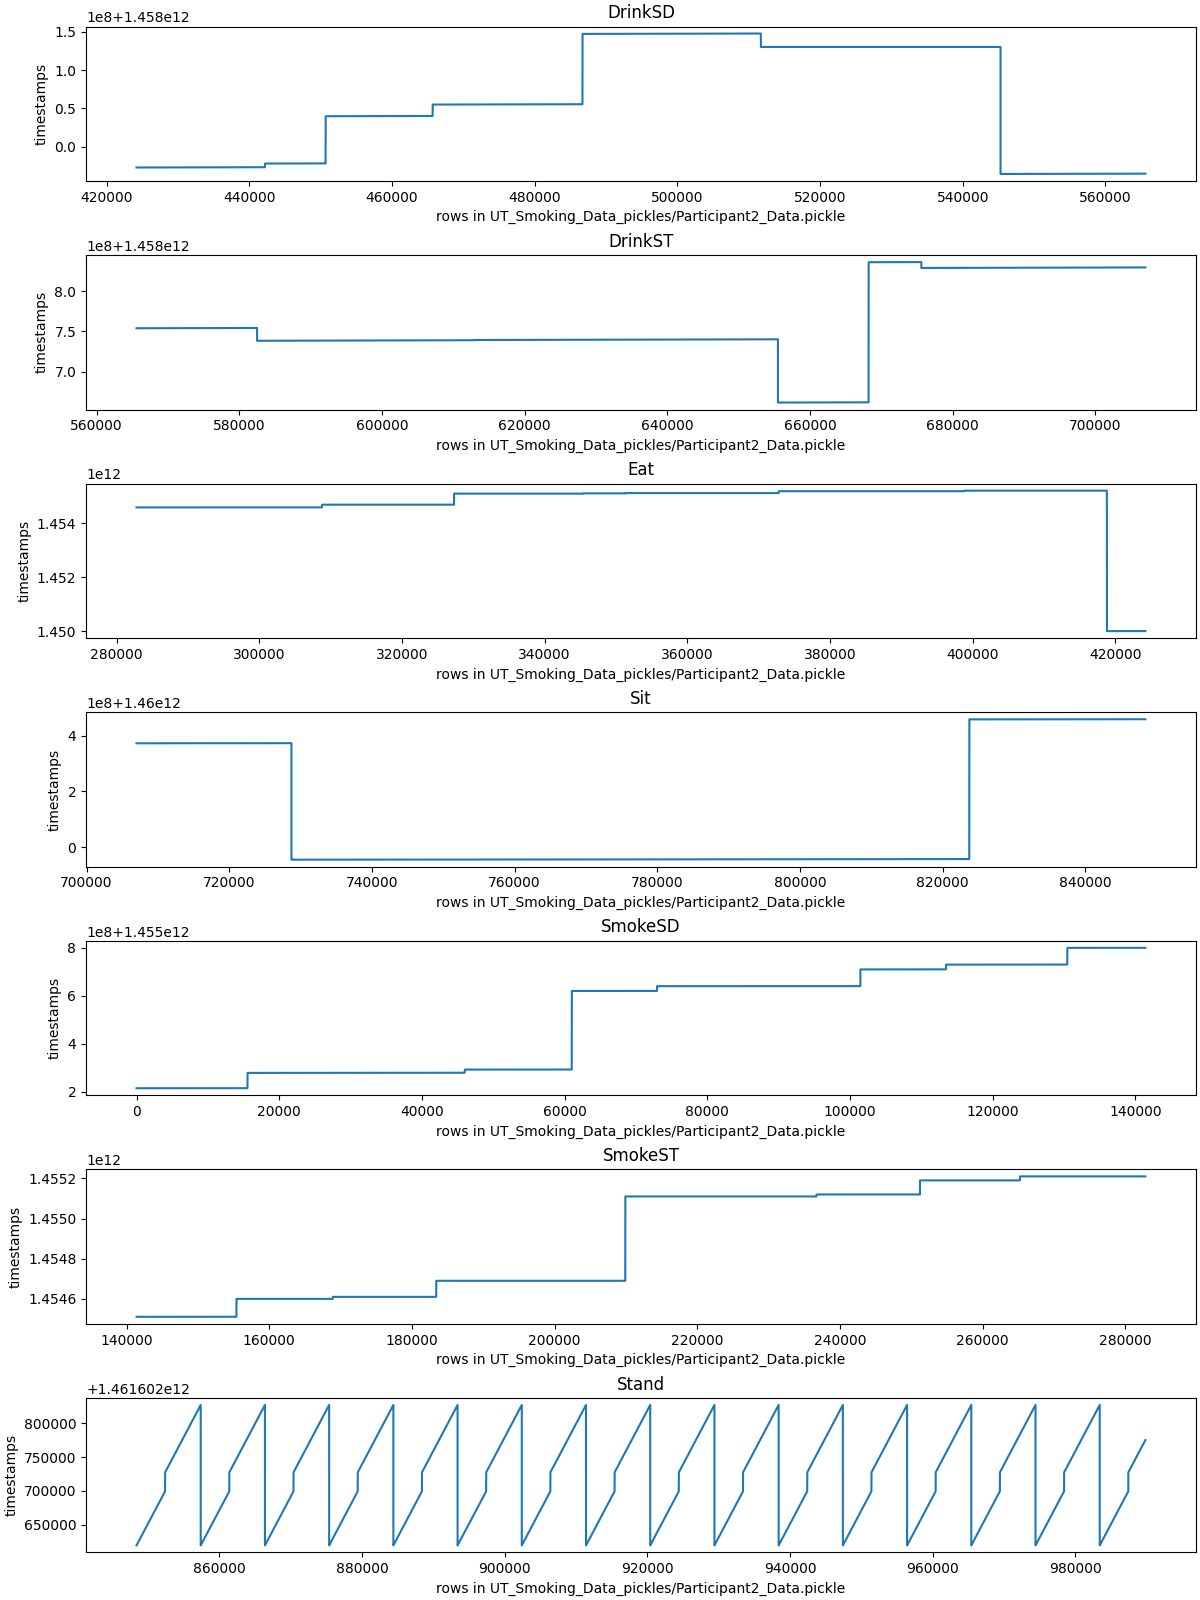

In [48]:
participant="Participant2"
fname='{}/{}_Data.pickle'.format(pickles_dir, participant)
data = pd.read_pickle(fname)
print_act_ts(fname, data)

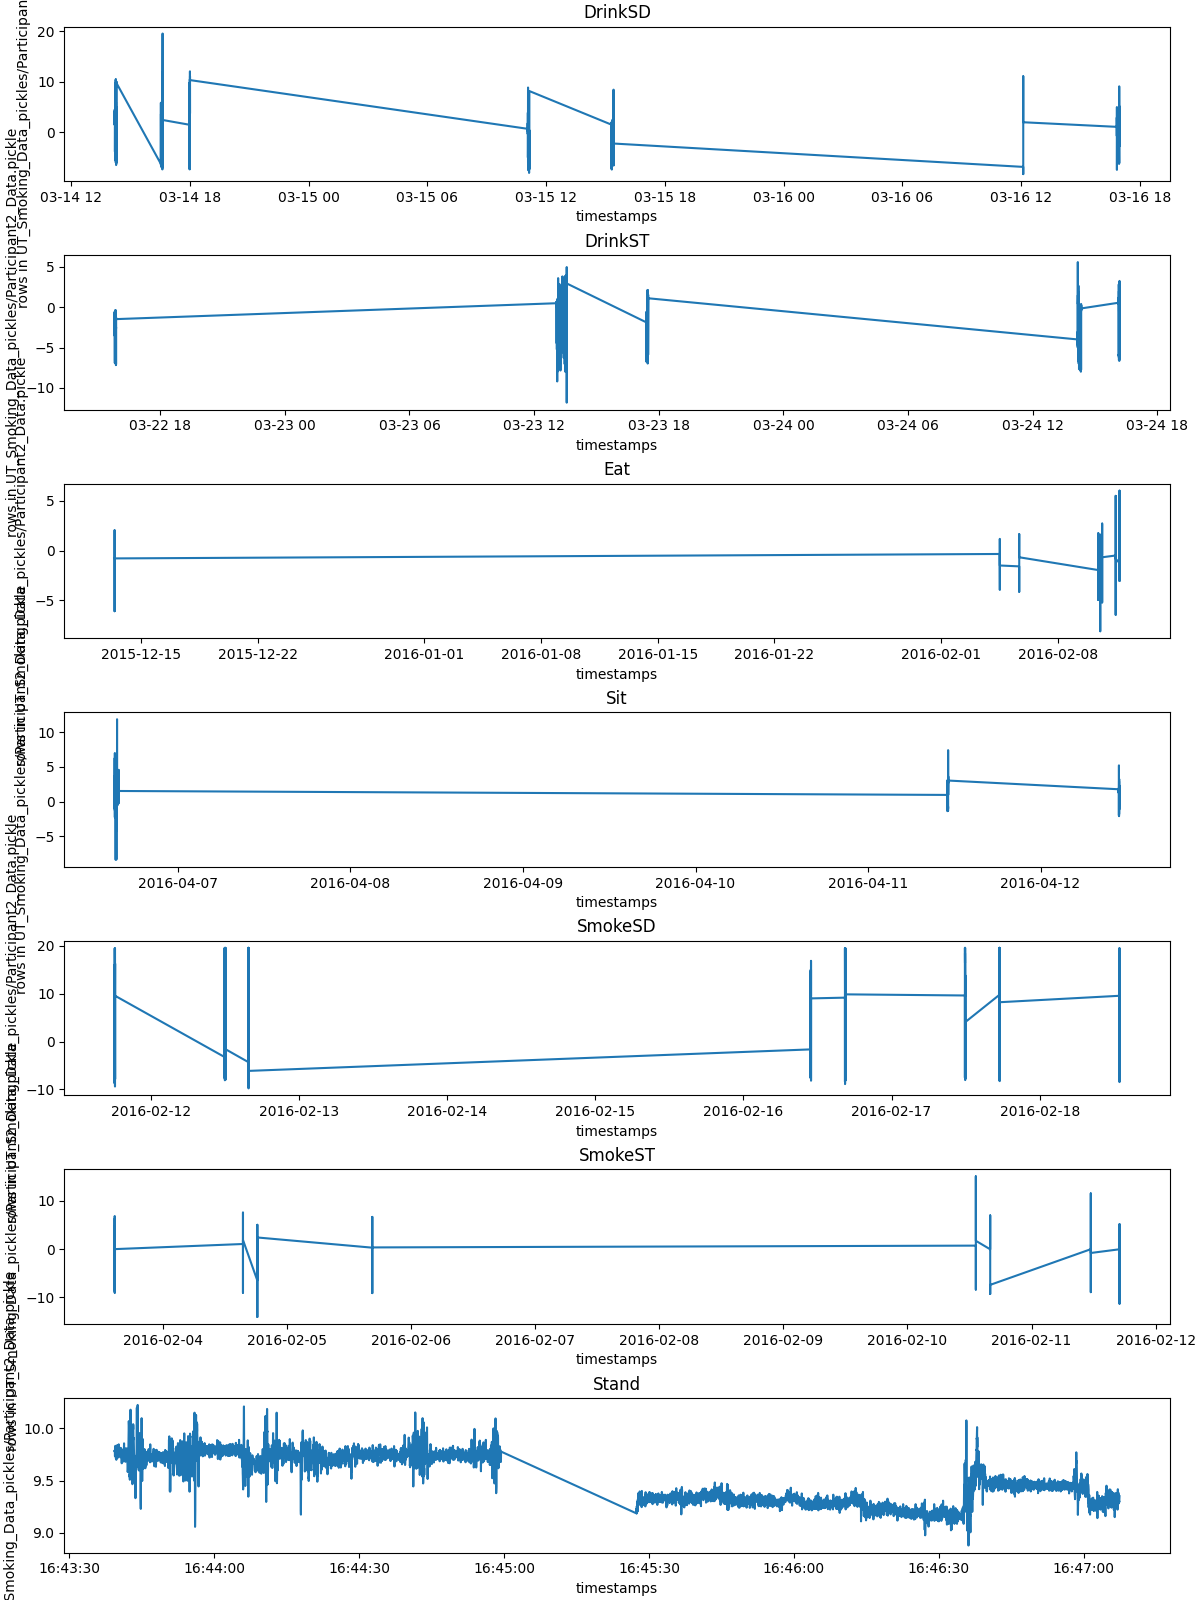

In [59]:
participant="Participant2"
fname='{}/{}_Data.pickle'.format(pickles_dir, participant)
data = pd.read_pickle(fname)
data2=data.sort_values(by=ts_field, ignore_index=True)
data2=data2.reset_index(drop=True)
print_act_ts_inv(fname, data2)

In [14]:
#lets build jpegs from sensor data, it's fun for feature engineering...
#here we work just on a single participant

ts_field='datime_WD'  #cleaned up one

participant="Participant2"
fname='{}/{}_Data.pickle'.format(pickles_dir, participant)

def to_255(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data)) * 255

sensor="gyro"

# our rgb-likes & sensor weights
if sensor == "accel" :  
  sensors=['Accelerometer_x_WD', 
           'Accelerometer_y_WD', 
           'Accelerometer_z_WD'] 
  sensors_weights={ "Accelerometer_x_WD": 5.0, 
                    "Accelerometer_y_WD": 5.0, 
                    "Accelerometer_z_WD": 1.0 }

if sensor == "accel_lin" :  
  sensors=['Linear_acceleration_sensor_x_WD', 
           'Linear_acceleration_sensor_y_WD', 
           'Linear_acceleration_sensor_z_WD'] 
  sensors_weights={ "Linear_acceleration_sensor_x_WD": 1.0,
                    "Linear_acceleration_sensor_y_WD": 1.0, 
                    "Linear_acceleration_sensor_z_WD": 1.0 }

if sensor == "gyro" :
  sensors=['Gyroscope_x_PD', 
           'Gyroscope_y_PD', 
           'Gyroscope_z_PD'] 
  sensors_weights={ "Gyroscope_x_PD": 1.0, 
                    "Gyroscope_y_PD": 1.0, 
                    "Gyroscope_z_PD": 5.0 }
    
sampling=50 #sampling rate
win_len=60  #wind size in secs

n_sensors=len(sensors) #outta be [1,3] for images...

tot_frame_len=int(sampling*win_len)

act_types=np.sort(data[categ_colname].unique())
n_act_types=len(act_types)

#build images lists
act_rgb={} #images per activity 

max_count = int(len(data)/tot_frame_len)
print("expecting approx {} images in total...".format(max_count))

pbar = IntProgress(min=0, max=max_count) 
display(pbar) 

def act_2_rgb(data, act_rgb, act_type):
  data_cursor = data[(data[categ_colname] == act_type)].copy() 
  data_act_type_len=len(data_cursor)-tot_frame_len
                         
  if data_act_type_len < tot_frame_len : 
     print("start skipping {} cur not enugh for at least 1 frame...".format(act_type))
     return

  data2=data_cursor.sort_values(by=ts_field, ignore_index=True)
  data_cursor=data2.reset_index(drop=True)

  act_rgb[act_type]=[]

  max_count_act = int(len(data_cursor)/tot_frame_len)
  print("expecting approx {} {} images in total...".format(act_type, max_count_act))
    
  nth_frame=0 
  
  while True:      
    cur_pos=nth_frame*tot_frame_len
    if cur_pos > data_act_type_len :   break           
    end_pos=cur_pos+tot_frame_len    
    data_tmp=data_cursor[cur_pos:end_pos] 
    
    #fill rgb frame from data_tmp...
    raw_data = [] 
    _cur_pos = 0
        
    for nth_sec in range(0, win_len) :
      if _cur_pos == tot_frame_len :  break
        
      for nrow in range(0, sampling) :
         _cur_pos=sampling*nth_sec+nrow
         if _cur_pos == tot_frame_len : break           
         row=data_tmp.iloc[_cur_pos]            

         for fld in sensors :
            raw_data.append(row[fld] * sensors_weights[fld])          
    
    act_rgb[act_type].append(Image.fromarray(np.array(to_255(raw_data), dtype=np.uint8).reshape(sampling, win_len, n_sensors))) 
    nth_frame+=1
        
    pbar.value += 1   
    if pbar.value % 20 == 0:
       print("{} images of {}".format(20, act_type))
    
  print("processed {} frames of {}".format(nth_frame, act_type))
  return

for act_type in act_types :
   act_2_rgb(data, act_rgb, act_type)             

expecting approx 329 images in total...


IntProgress(value=0, max=329)

expecting approx DrinkSD 47 images in total...
20 images of DrinkSD
20 images of DrinkSD
processed 47 frames of DrinkSD
expecting approx DrinkST 47 images in total...
20 images of DrinkST
20 images of DrinkST
processed 47 frames of DrinkST
expecting approx Eat 47 images in total...
20 images of Eat
20 images of Eat
20 images of Eat
processed 47 frames of Eat
expecting approx Sit 47 images in total...
20 images of Sit
20 images of Sit
processed 47 frames of Sit
expecting approx SmokeSD 47 images in total...
20 images of SmokeSD
20 images of SmokeSD
processed 47 frames of SmokeSD
expecting approx SmokeST 47 images in total...
20 images of SmokeST
20 images of SmokeST
20 images of SmokeST
processed 47 frames of SmokeST
expecting approx Stand 47 images in total...
20 images of Stand
20 images of Stand
processed 47 frames of Stand


In [10]:
for act_type in act_types :    
  print("made {} frames for activty {}".format(len(act_rgb[act_type]), act_type))

made 47 frames for activty DrinkSD
made 47 frames for activty DrinkST
made 47 frames for activty Eat
made 47 frames for activty Sit
made 47 frames for activty SmokeSD
made 47 frames for activty SmokeST
made 47 frames for activty Stand


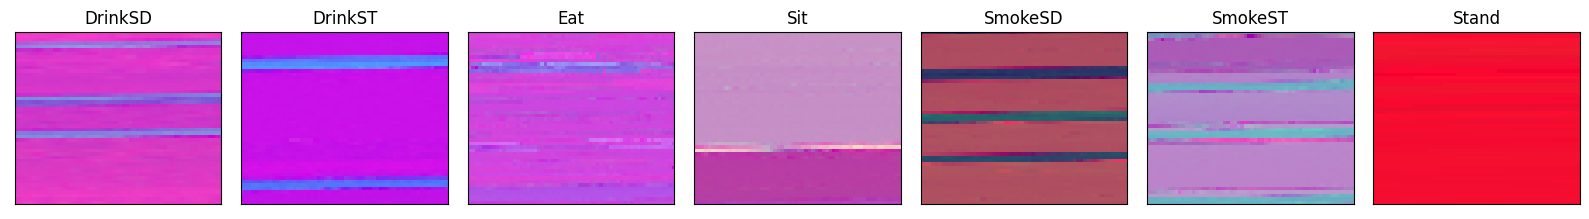

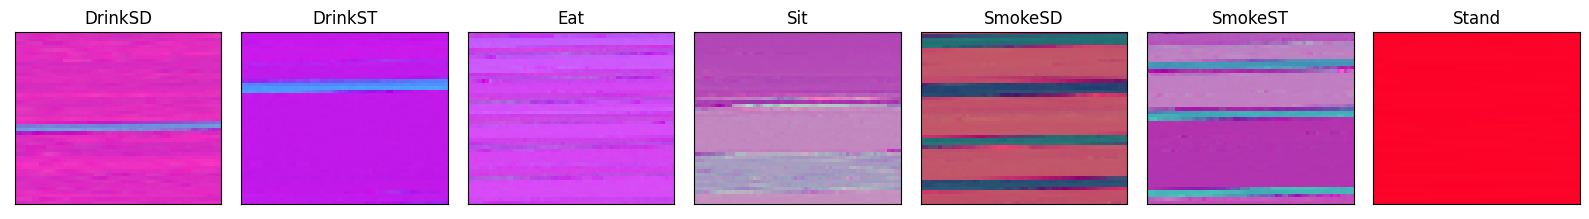

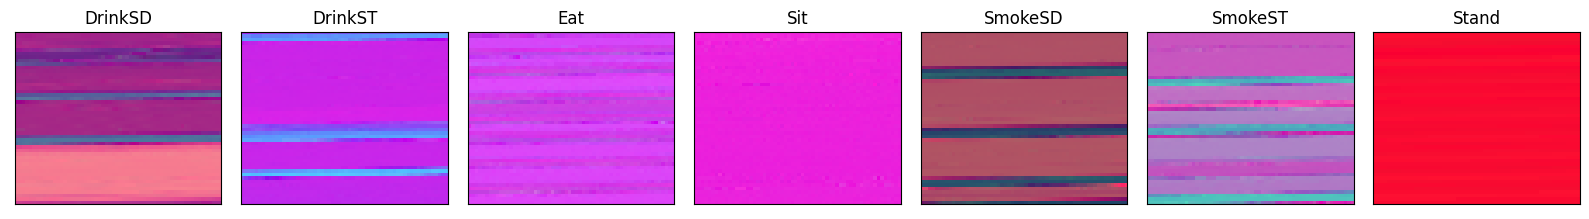

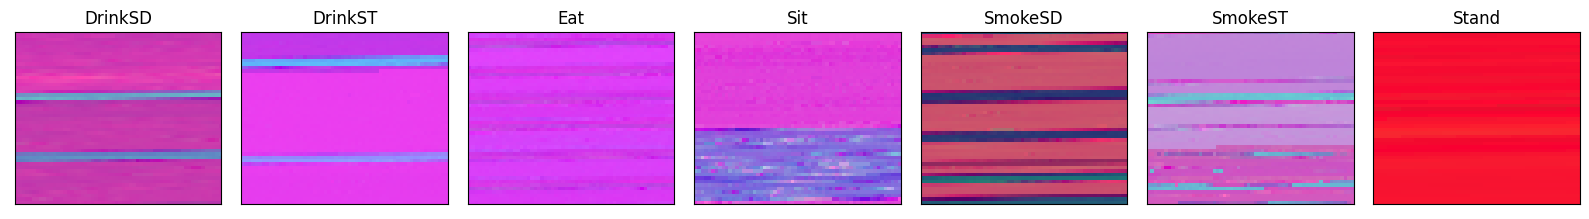

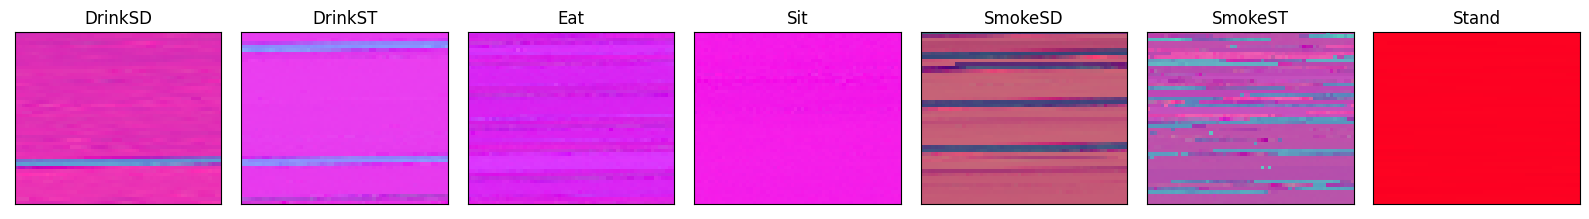

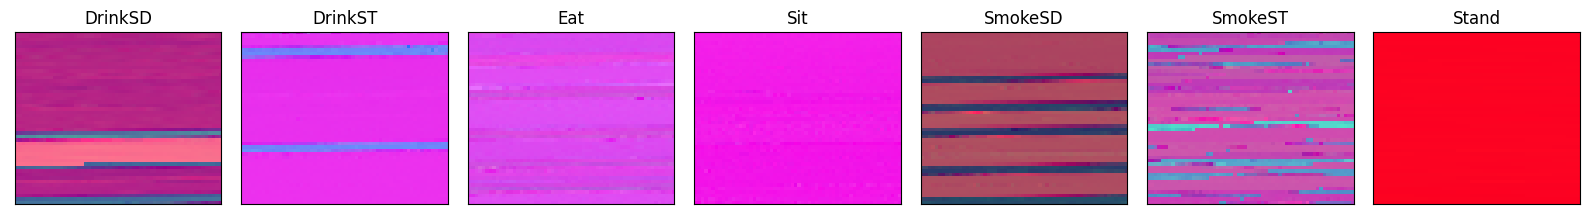

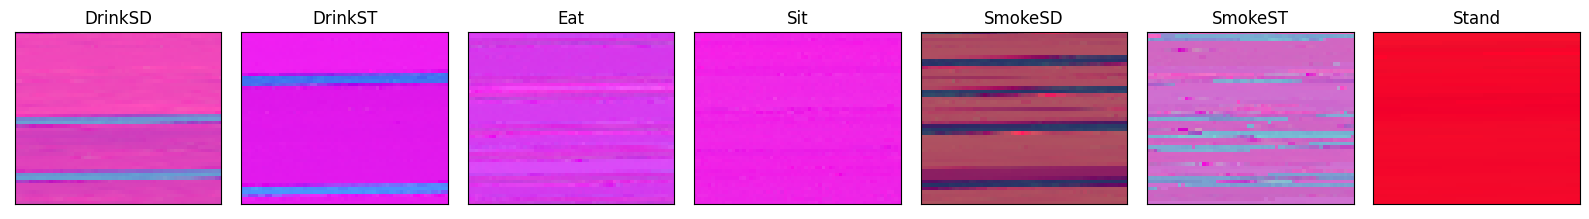

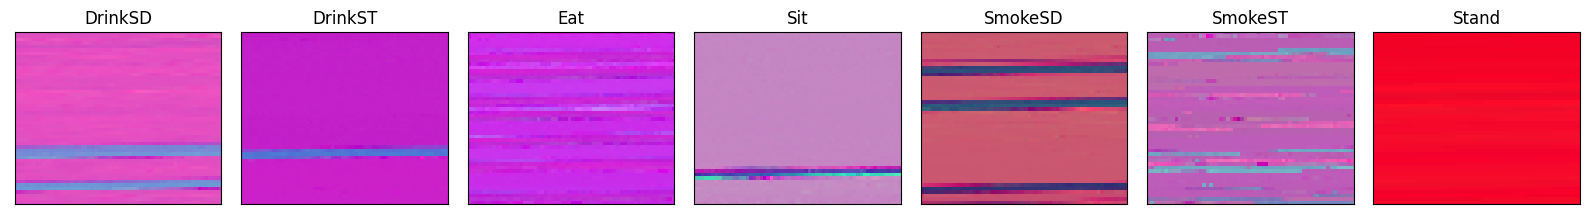

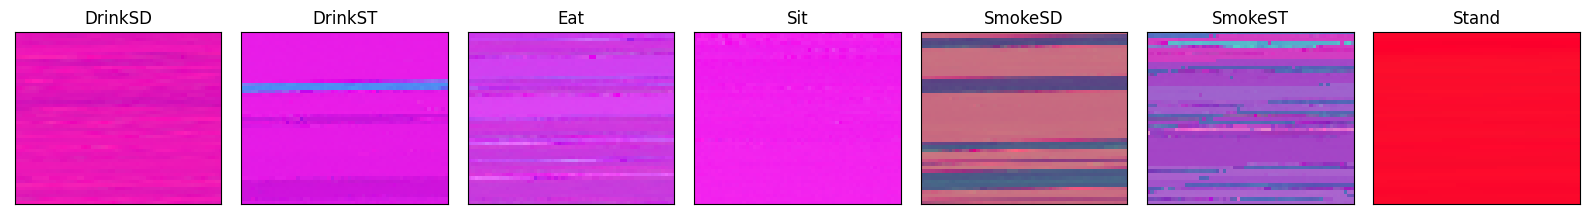

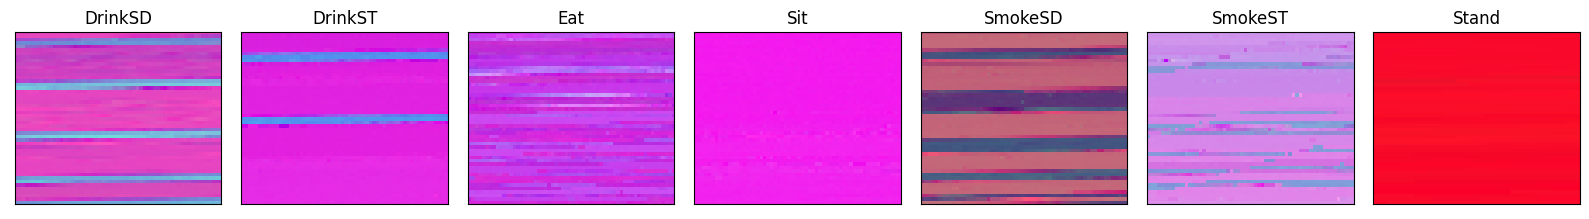

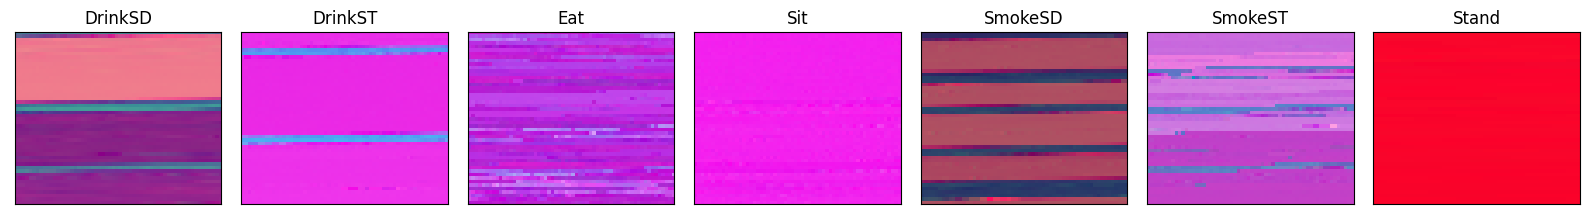

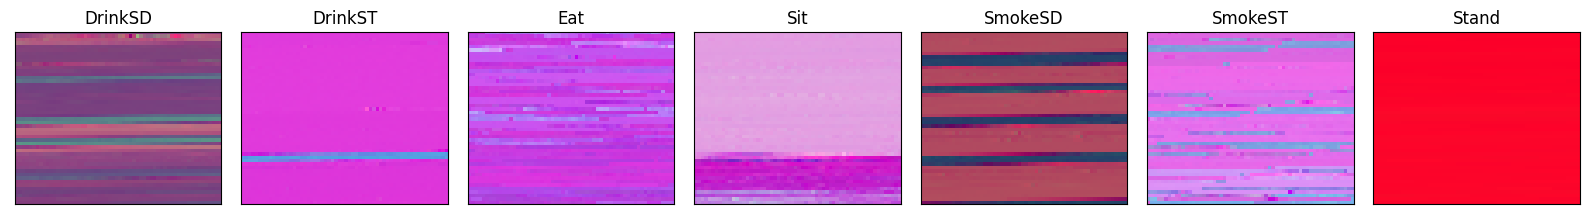

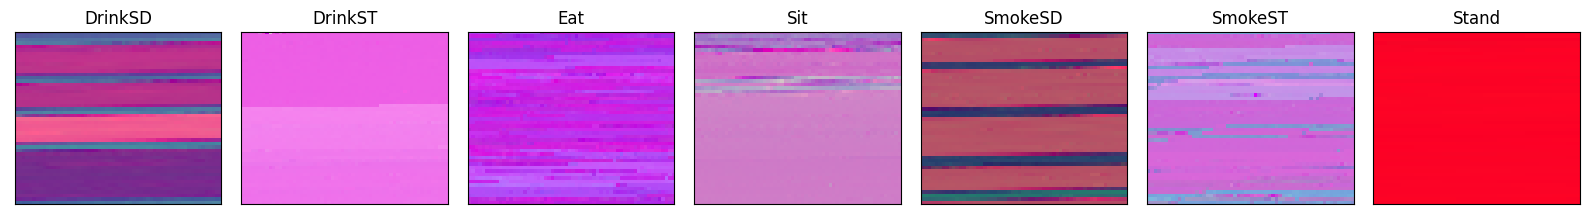

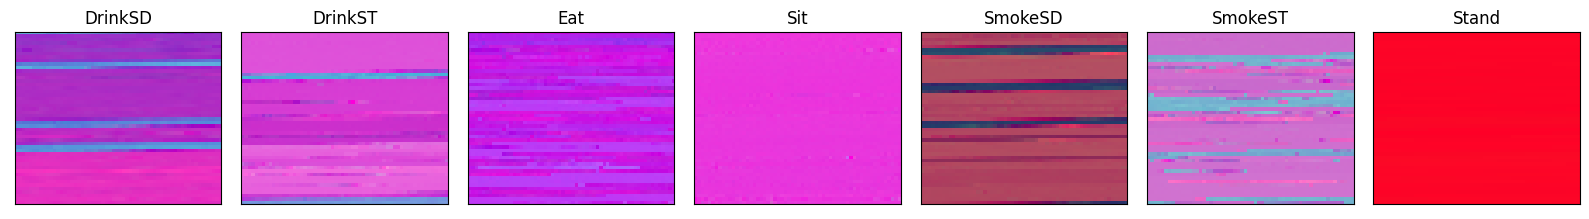

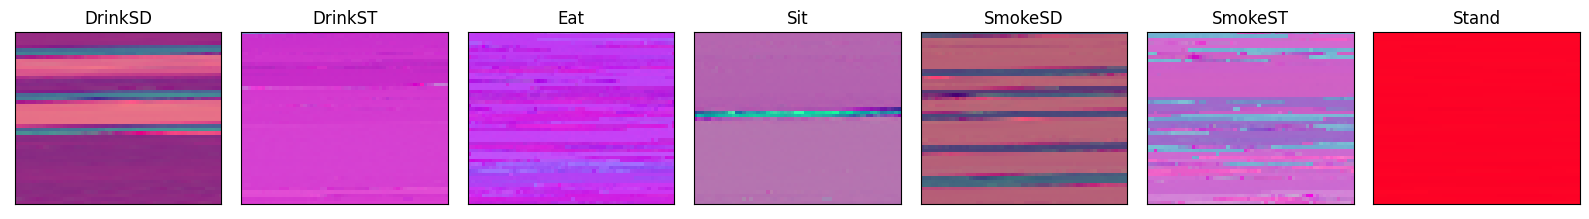

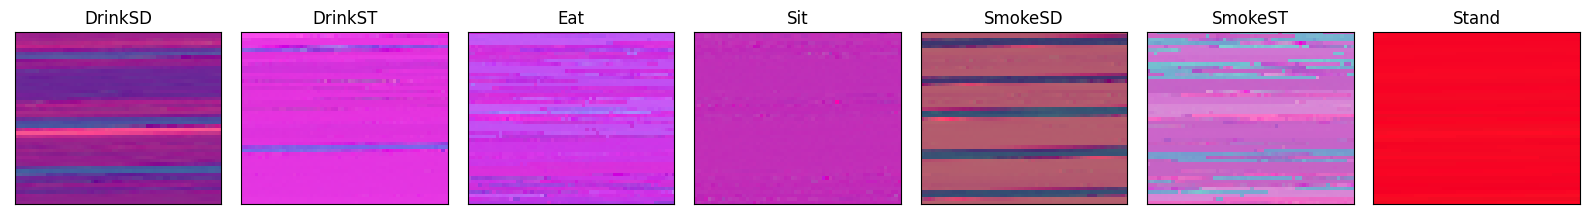

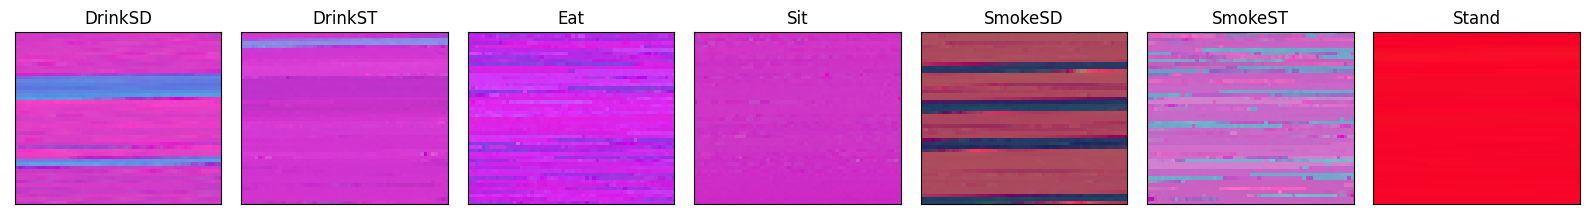

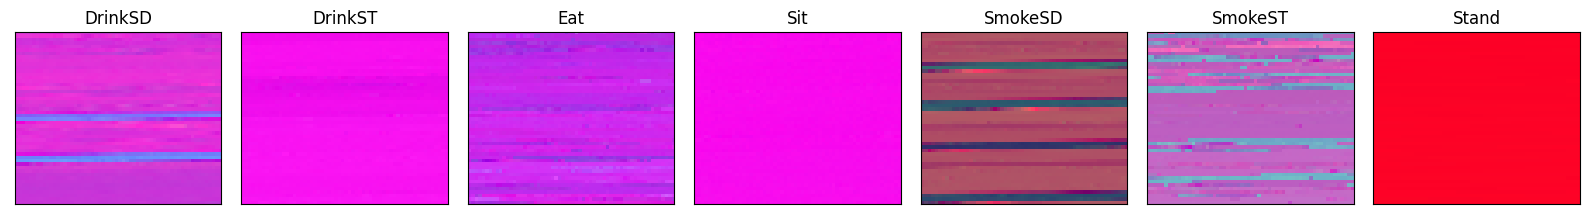

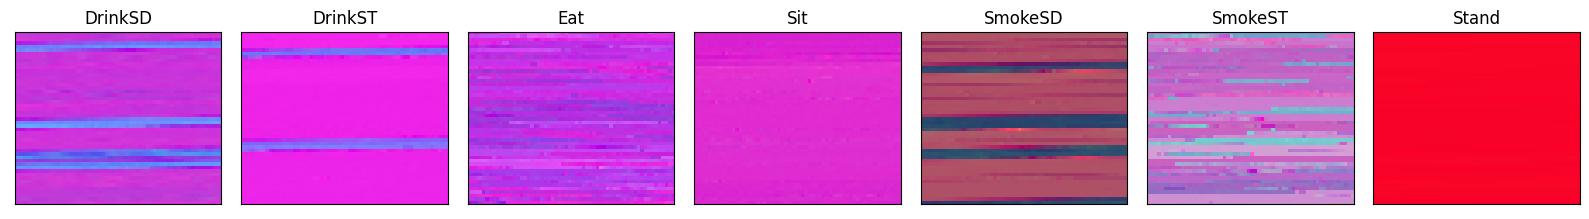

In [11]:
#keep made images in book...
if sensor == "accel" : 
    for n_row in range(1,20):
      n_act=0
      fig, axs = plt.subplots(1, n_act_types, figsize=(16, 9))
      for i in range(n_act_types):
        ax = axs[i]
        ax.set_title(f'{act_types[n_act]}', size=12)
        ax.set_xticks(()), ax.set_yticks(())
        ax.imshow(act_rgb[act_types[n_act]][n_row])
        n_act=n_act+1
      plt.tight_layout()

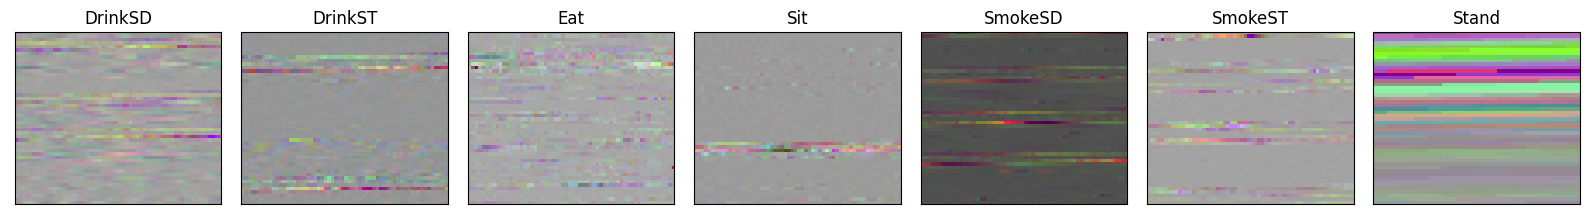

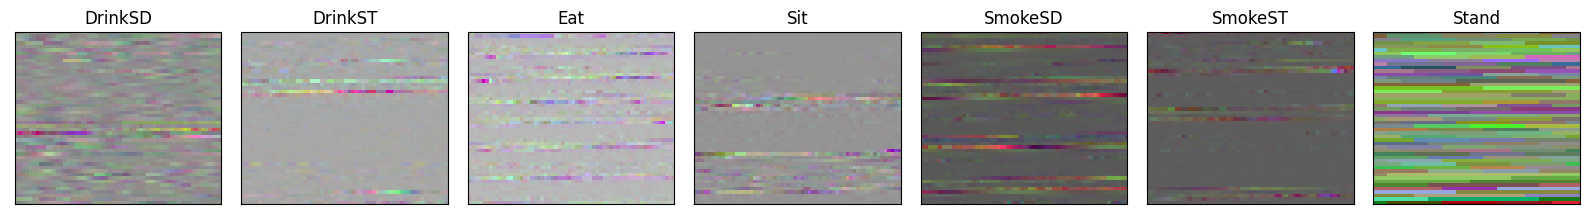

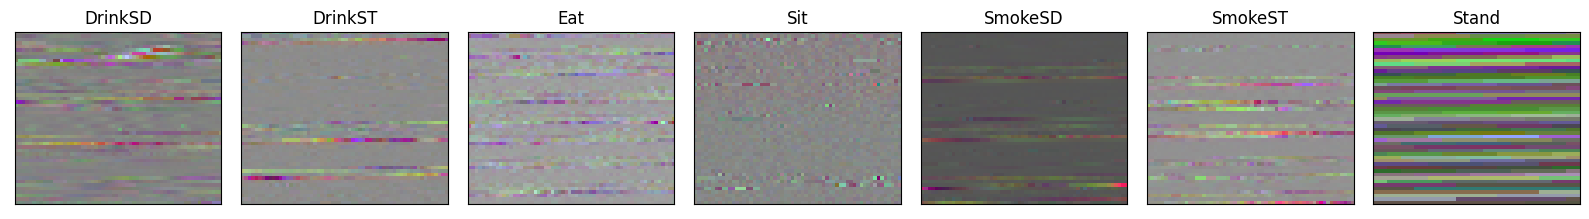

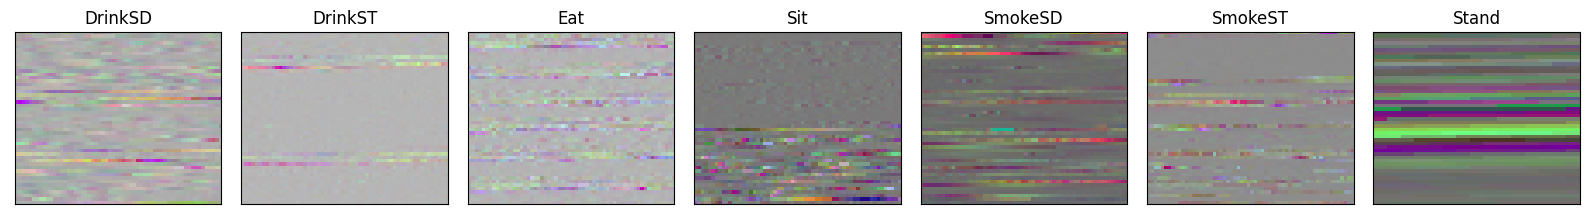

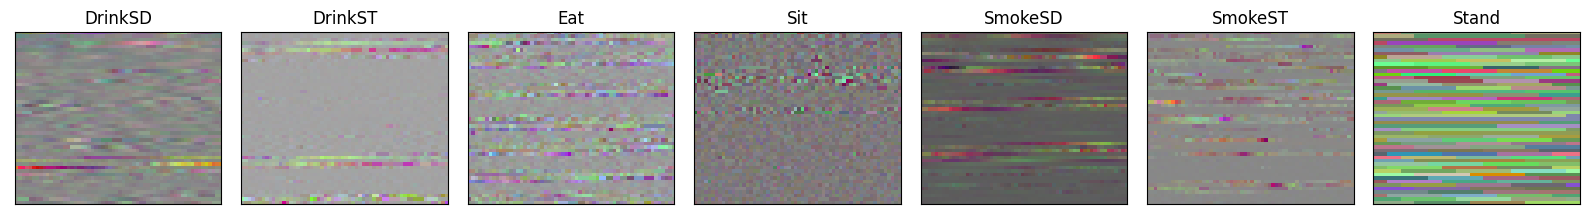

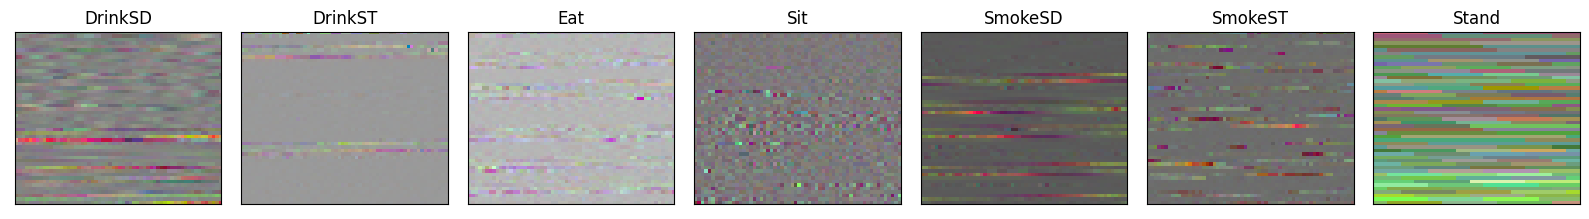

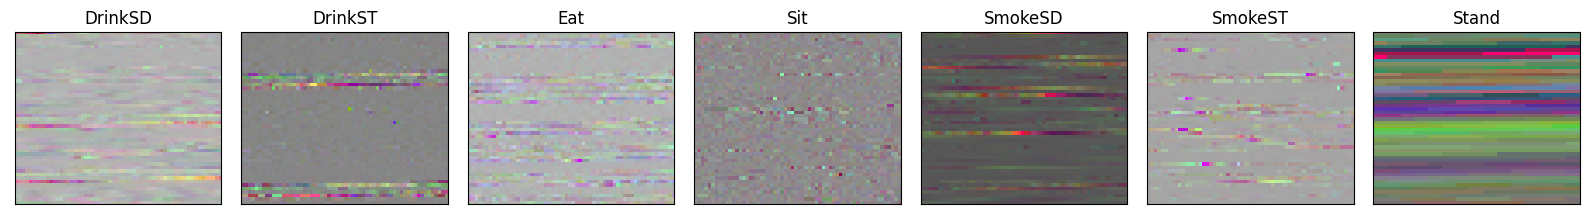

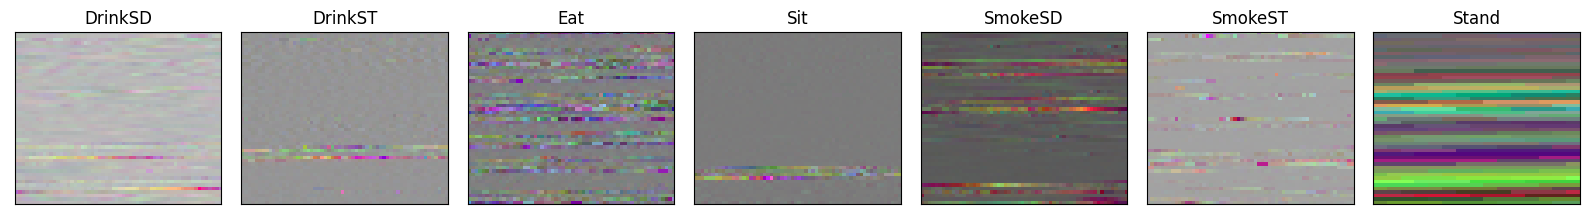

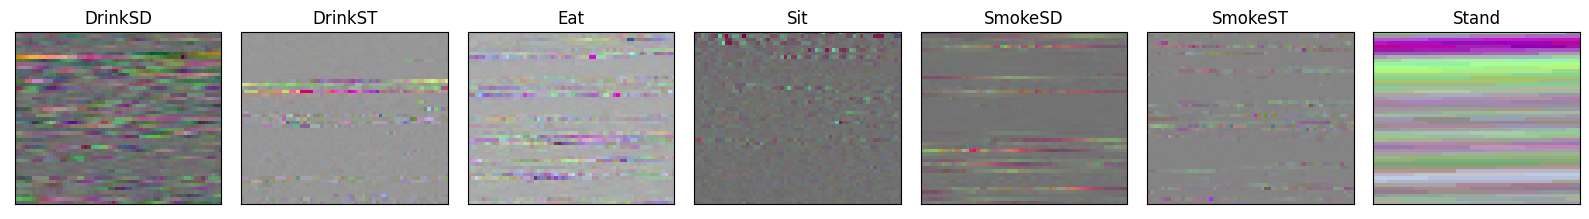

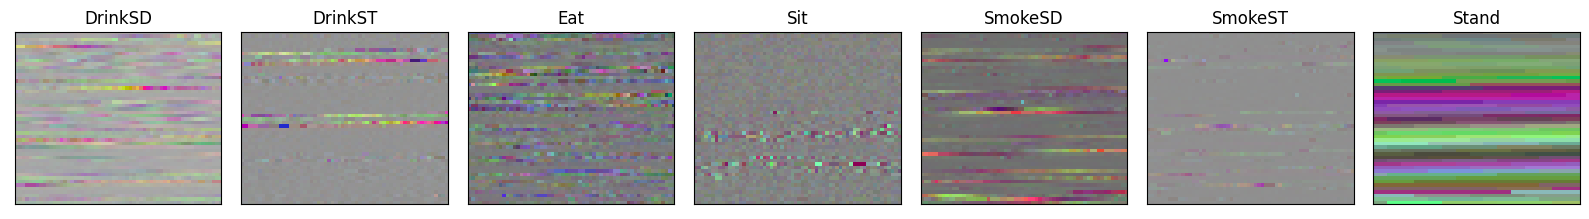

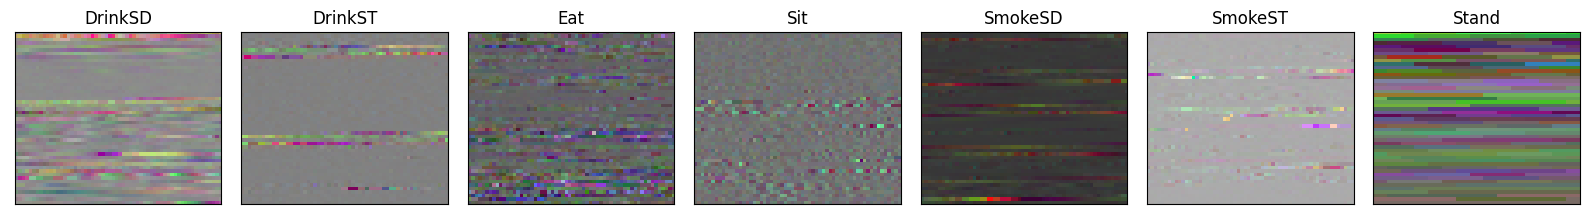

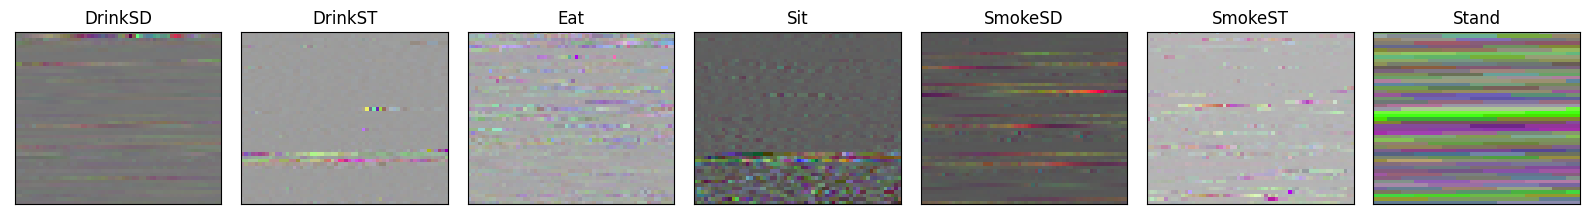

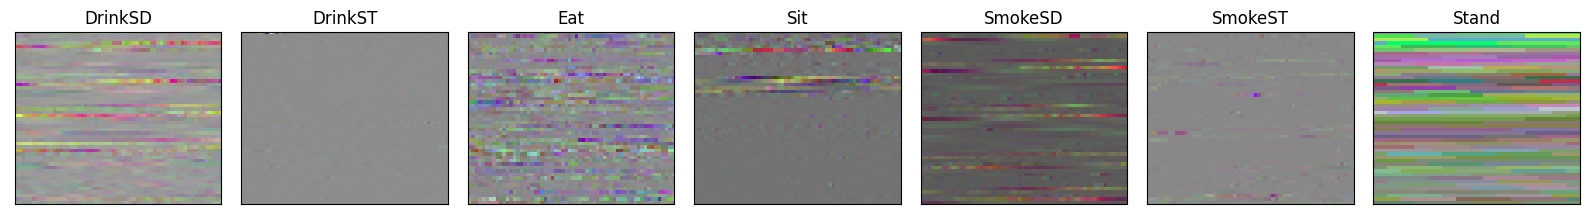

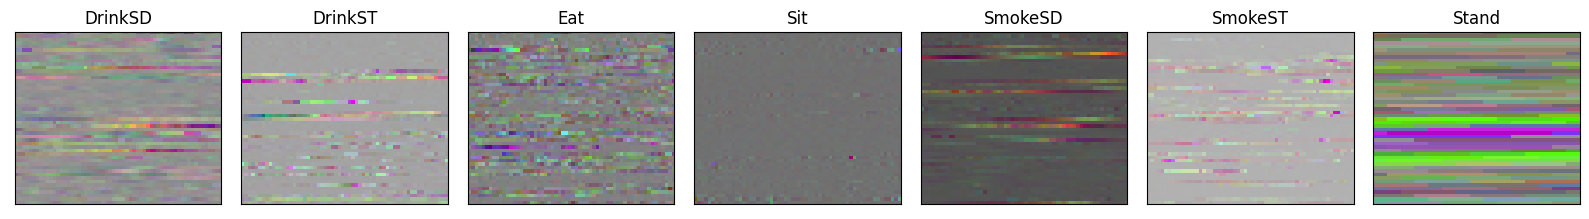

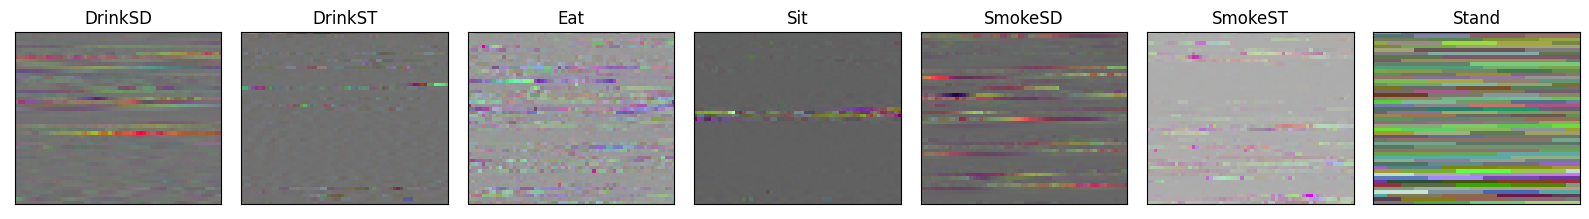

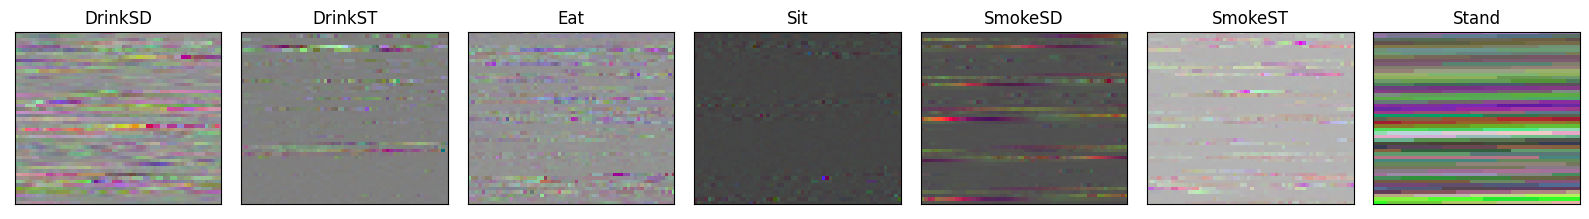

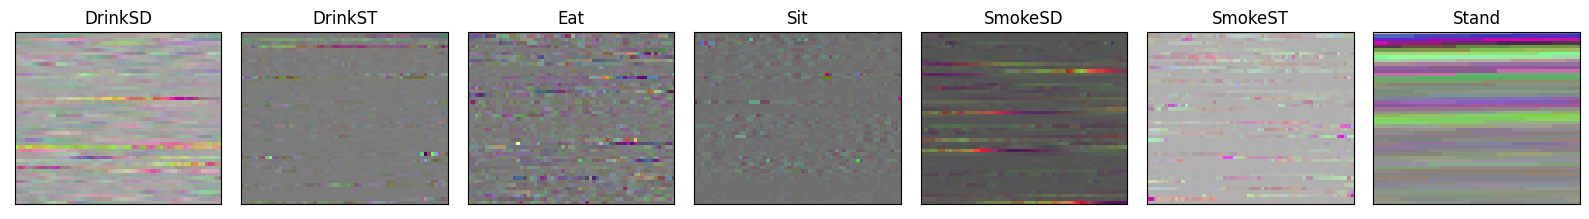

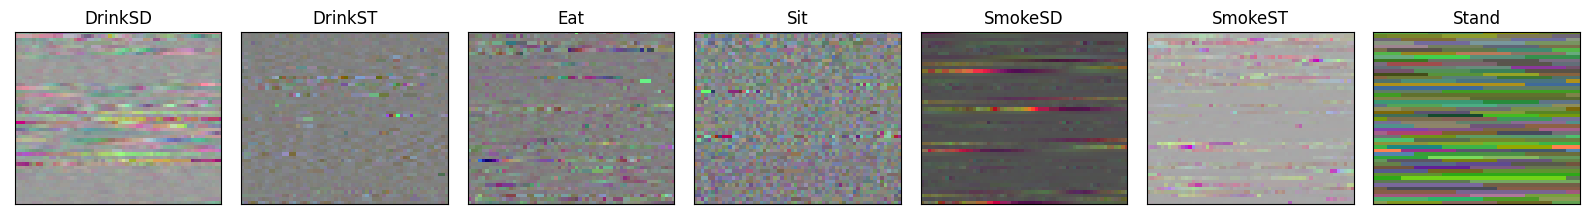

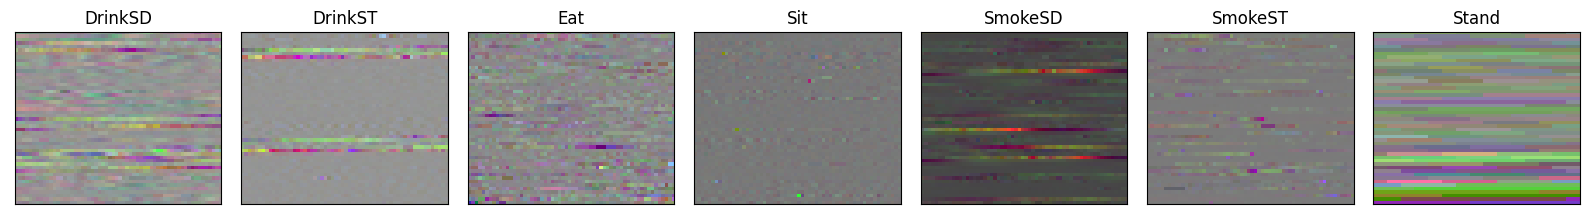

In [13]:
#keep images in book...
if sensor == "accel_lin" : 
    for n_row in range(1,20):
      n_act=0
      fig, axs = plt.subplots(1, n_act_types, figsize=(16, 9))
      for i in range(n_act_types):
        ax = axs[i]
        ax.set_title(f'{act_types[n_act]}', size=12)
        ax.set_xticks(()), ax.set_yticks(())
        ax.imshow(act_rgb[act_types[n_act]][n_row])
        n_act=n_act+1
      plt.tight_layout()

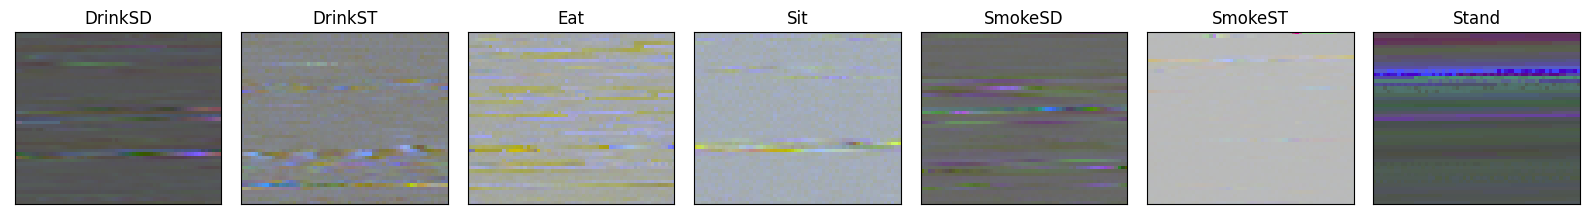

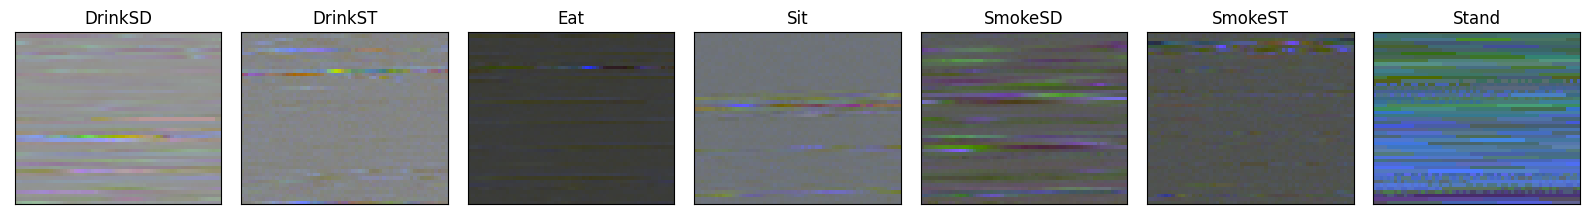

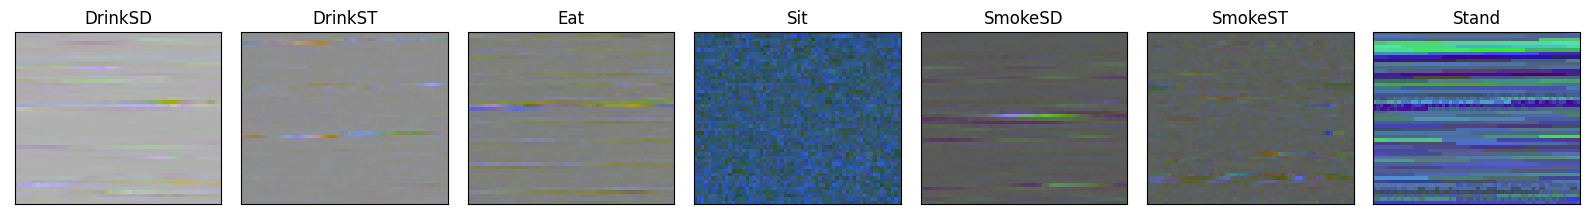

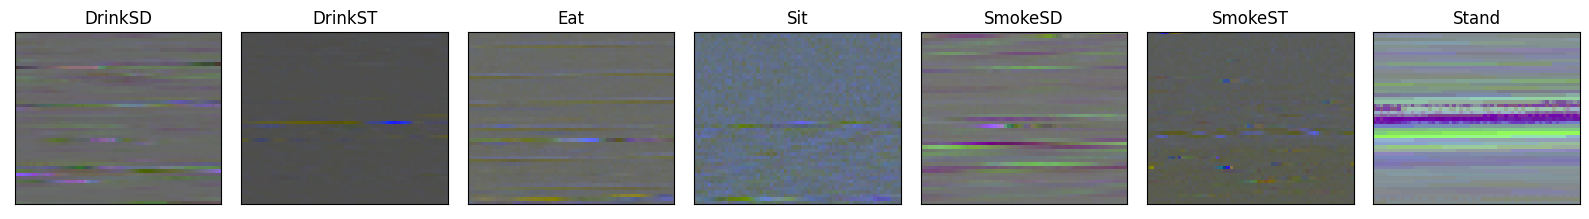

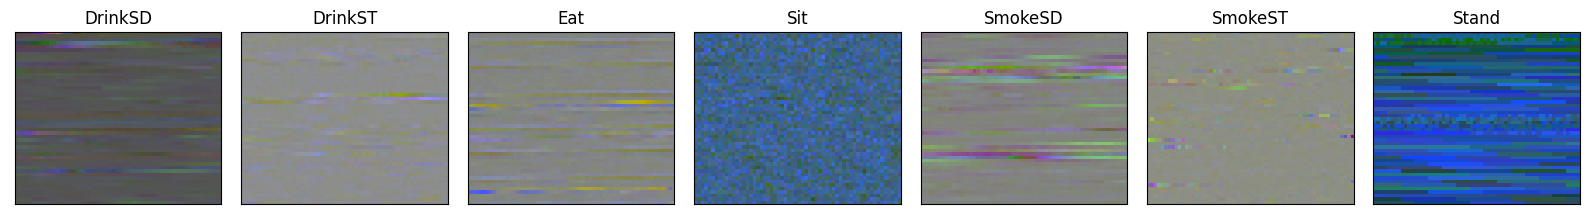

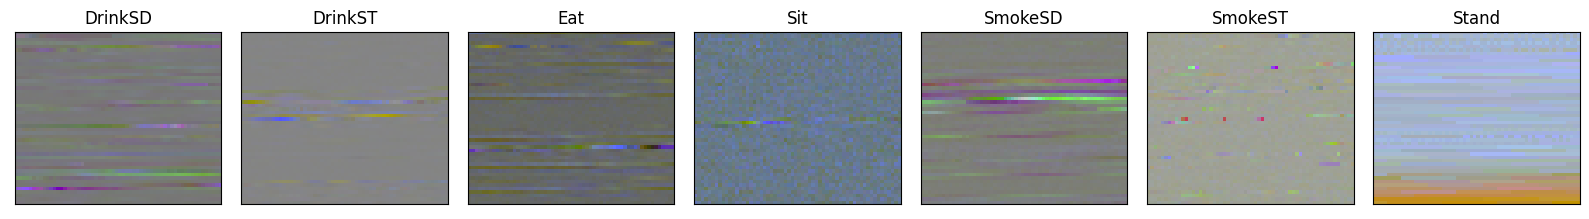

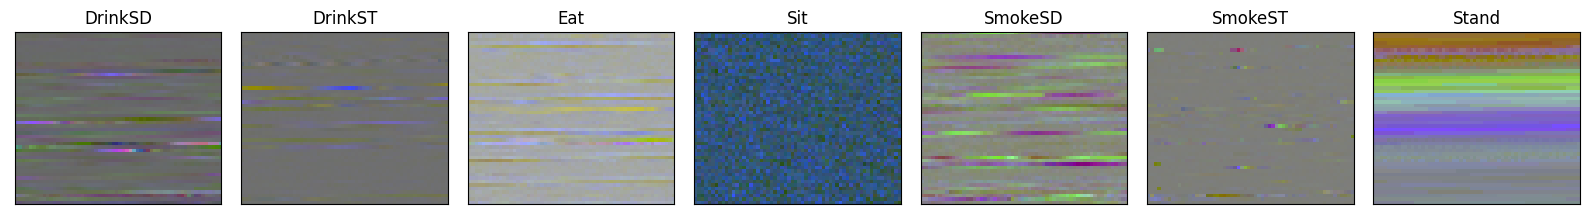

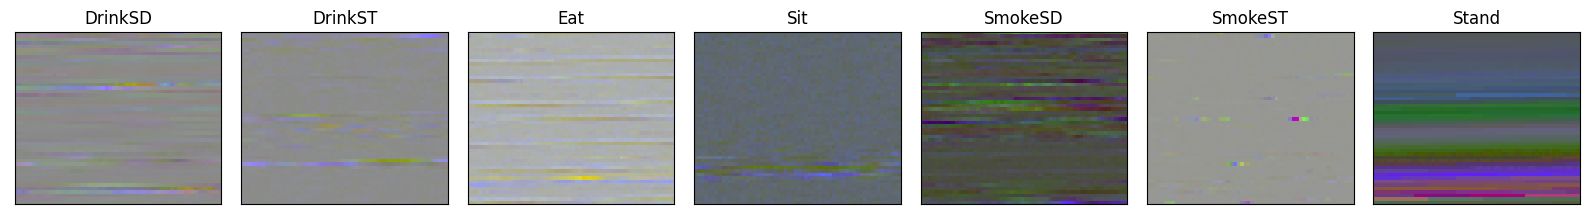

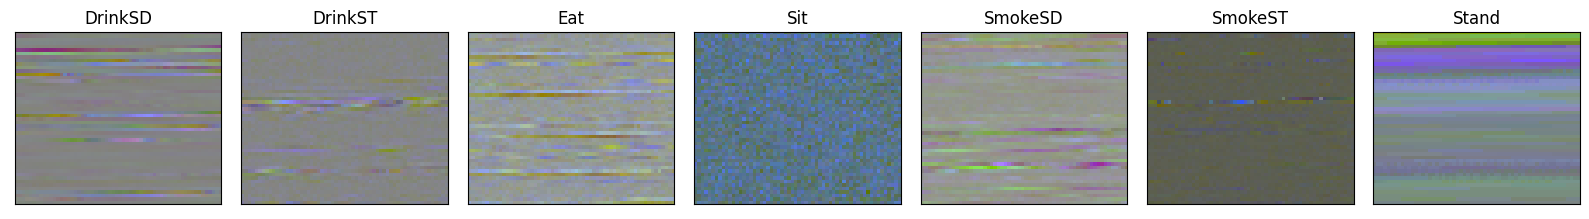

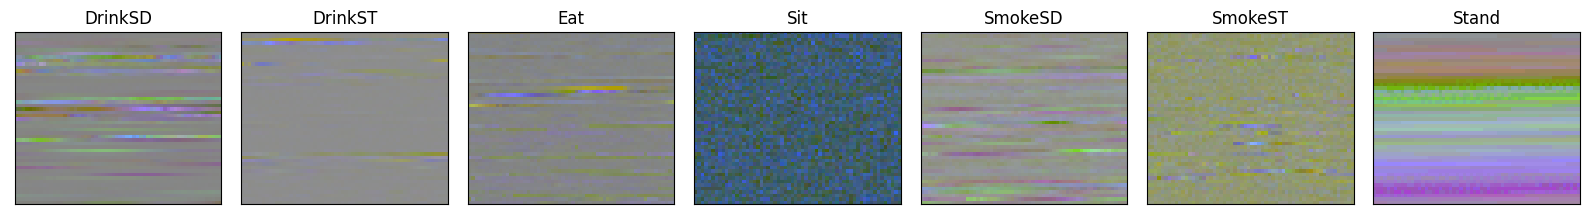

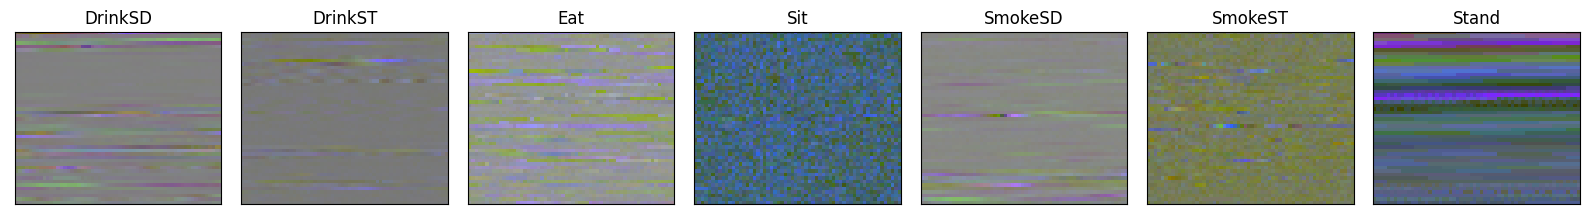

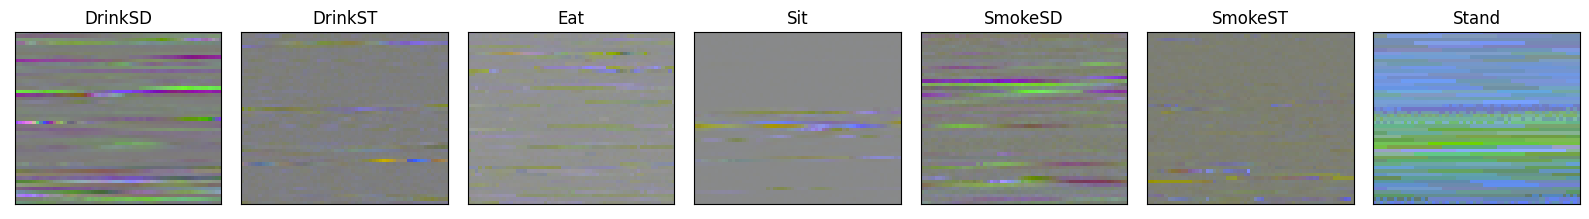

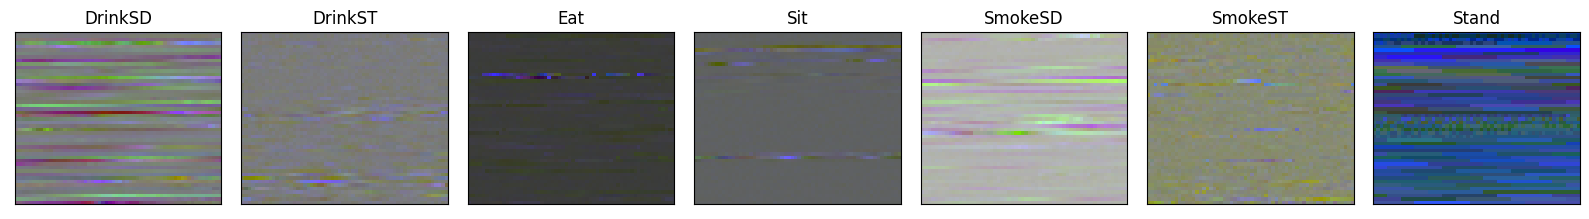

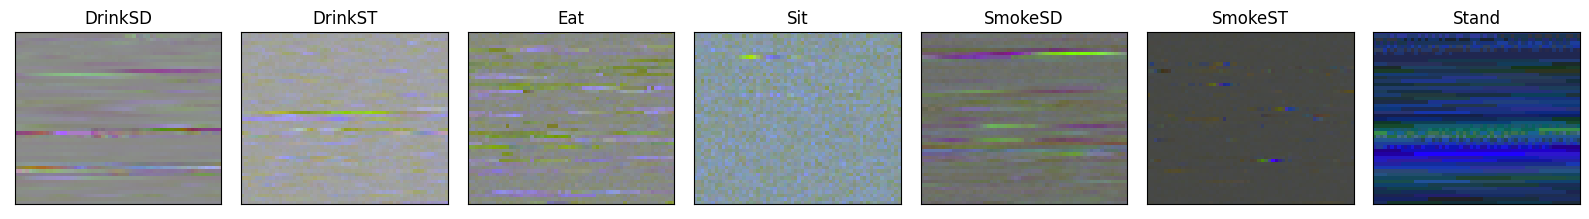

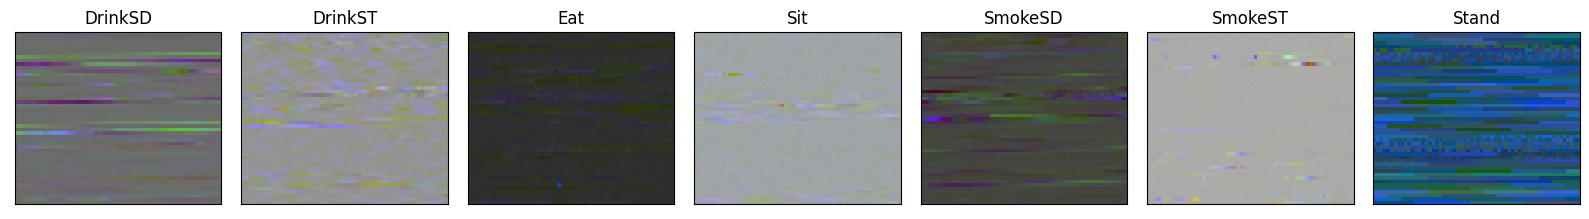

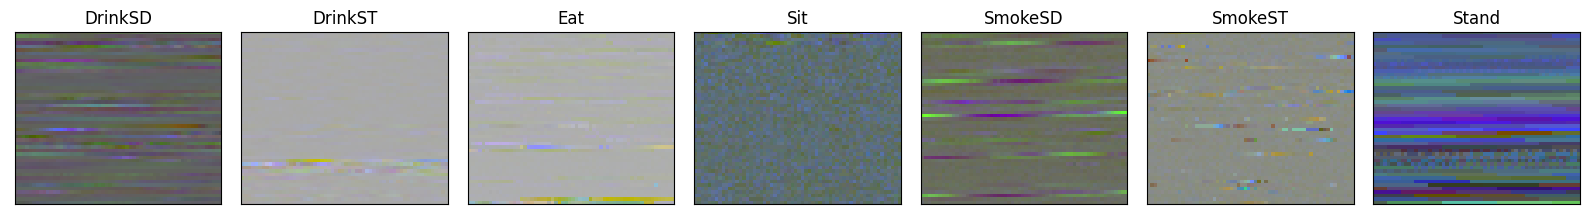

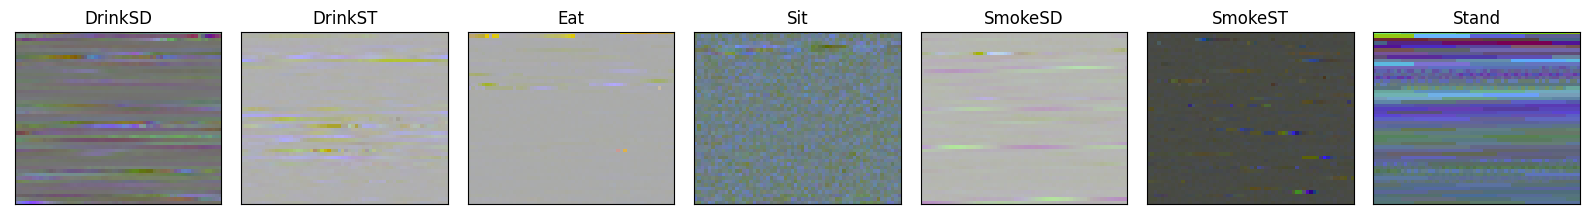

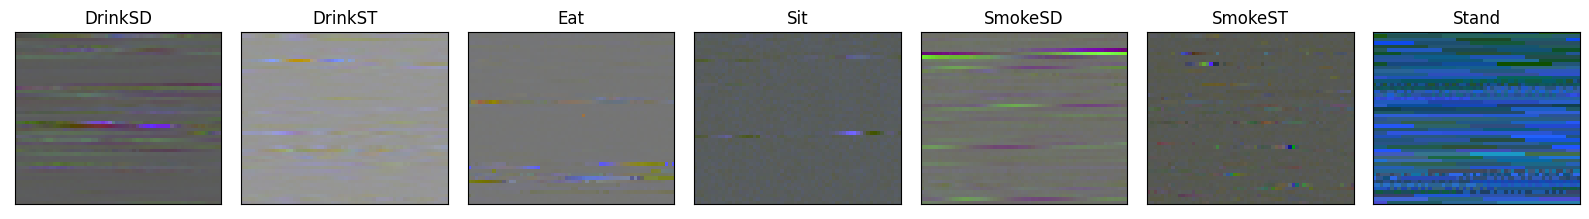

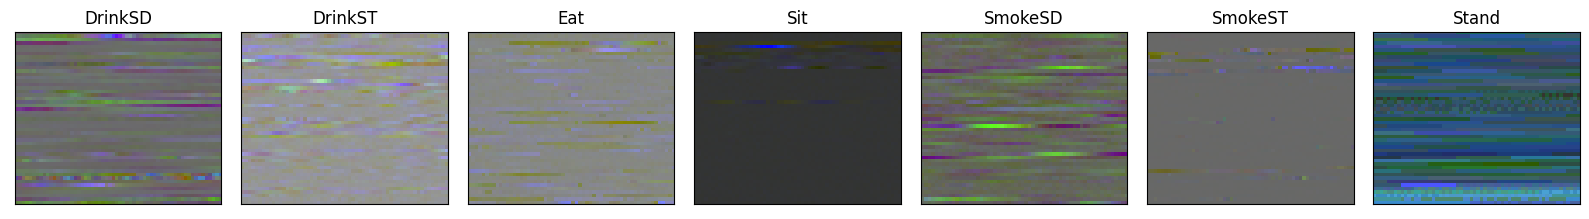

In [15]:
#keep images in book...
if sensor == "gyro" : 
    for n_row in range(1,20):
      n_act=0
      fig, axs = plt.subplots(1, n_act_types, figsize=(16, 9))
      for i in range(n_act_types):
        ax = axs[i]
        ax.set_title(f'{act_types[n_act]}', size=12)
        ax.set_xticks(()), ax.set_yticks(())
        ax.imshow(act_rgb[act_types[n_act]][n_row])
        n_act=n_act+1
      plt.tight_layout()

In [ ]:
for f_in in os.listdir(pickles_dir): 
    if not (f_in.startswith('Participant') and f_in.endswith('_Data.pickle')) : continue
    print(f_in)

In [137]:
##ok, it's ime to make X, y from a whole dataset...

sampling=50  #sampling rate
win_len=20   #wind size in secs

#overlap will add 2nd pass moving init windsow position...
#seems to add only 3% to prec/recall...

overlap=True 
overlap_len=(win_len-10)*sampling  #n secs overlap, dont make it neg !
                                  #here on overap pass we start nead the end of 1st frame
    
overlap_str="_with_overlap" if overlap else ""

feature_set="accel+gyro" # "accel" or "accel+gyro"

ignore_dudes = [ "Participant10" ]

sensors=['Accelerometer_x_WD', 
         'Accelerometer_y_WD', 
         'Accelerometer_z_WD'] 

sensors_weights={ "Accelerometer_x_WD": 5.0, 
                  "Accelerometer_y_WD": 5.0, 
                  "Accelerometer_z_WD": 1.0 }
    
# our rgb-likes & sensor weights
if feature_set == "accel+gyro" :  
  sensors.extend(['Gyroscope_x_PD', 
                  'Gyroscope_y_PD', 
                  'Gyroscope_z_PD'])
  sensors_weights.update({ "Gyroscope_x_PD": 1.0, 
                           "Gyroscope_y_PD": 1.0, 
                           "Gyroscope_z_PD": 5.0 })
    
tot_frame_len=sampling*win_len
n_sensors=len(sensors)

#prefer to hardcode expected act_types here...
act_types=[ 'DrinkSD', 'DrinkST', 'Eat', 'Sit', 'SmokeSD', 'SmokeST', 'Stand' ]
n_act_types=len(act_types)

id_str=str(len(sensors)) + "sensors_win" + str(win_len) + overlap_str

In [73]:
#someone should revite will cell ! it's so slow...!

ts_field='datime_WD'  #cleaned up one, 
                      #otherwise sort will die on timestamp_WD of participant1 

f_ins=[]
for f_in in os.listdir(pickles_dir):     
    # load raw from pickle    
    if not (f_in.startswith('Participant') and f_in.endswith('_Data.pickle')) : continue
     
    skip_this_one=False
    for dude in ignore_dudes :
        if f_in.startswith(dude):
            print ("skipping {}".format(dude))
            skip_this_one=True
            break        
    if skip_this_one: continue        
    f_ins.append(f_in)

n_files=len(f_ins)
if n_files == 0 :
    raise("no pickles to process!..")

    
X_act_data={} #final dict (par participant) with dicts {acivity:[list of frames of res_y duration]}

n_participant=0
participants=[]

for f_in in f_ins:     
    
    n_files-=1
    print("prcessing {}, {} more left".format(f_in, n_files))

    data = pd.read_pickle(os.path.join(pickles_dir, f_in)) 
       
    act_types_in_file=np.sort(data[categ_colname].unique())
    
    if len(act_types_in_file) != n_act_types :
        
       if n_act_types > len(act_types_in_file) :         
         diff_acts=list(set(act_types) - set(act_types_in_file))
       else:
         diff_acts=list(set(act_types_in_file) - set(act_types)) 
       
       print("achtung, file {} has new or missing activities...".format(f_in, ", ".join(diff_acts))) 
   
    # make windows sets from raw...
    
    X_act_participant={} #will be appended to X_act_data after the loop is done...
    
    max_count = int(len(data)/tot_frame_len)
    if overlap : max_count+=max_count
        
    print("expecting approx {} images in total...".format(max_count))
    
    pbar = IntProgress(min=0, max=max_count) 
    display(pbar) 
        
    for act_type in act_types :
      data_cursor = data[(data[categ_colname] == act_type)].copy() 
      data_act_type_len=len(data_cursor)-tot_frame_len
      X_act_participant[act_type]=[]
    
      if data_act_type_len < tot_frame_len : 
        print("start skipping {} cur not enugh for at least 1 frame...".format(act_type))
        continue
      
      data2=data_cursor.sort_values(by=ts_field, ignore_index=True)
      data_cursor=data2.reset_index(drop=True)

      max_count_act = int(len(data_cursor)/tot_frame_len)
      if overlap : max_count_act += max_count_act
      print("expecting approx {} {} windows in total...".format(act_type, max_count_act))     
    
      nth_frame=0   
      overlap_shift=0
     
      _overlap=overlap
    
      while True:  
        cur_pos=nth_frame*tot_frame_len
        if cur_pos > data_act_type_len :  
          if not _overlap : break  
            
          #on overlap make 2nd pass shiting init cursor pos (i.e. beg of dataframe) 1/2 window len
          cur_pos       = 0
          nth_frame     = 0
          overlap_shift = overlap_len
          _overlap      = False
          print("overlap pass...")
            
        #====== start sliding window... 
        
        beg_row=nth_frame*tot_frame_len+overlap_shift
        end_row=beg_row+tot_frame_len
        
        #need chk it for overlap
        if overlap_shift !=0 and end_row >= data_act_type_len : break
        
        data_tmp=data_cursor[beg_row:end_row] 

        #fill frame from data_tmp...
        raw_data = [] 
        _cur_pos = 0
        
        for nth_sec in range(0, win_len):
          if _cur_pos == tot_frame_len :  break           
          for nrow in range(0, sampling):
             _cur_pos=sampling*nth_sec+nrow
             if _cur_pos == tot_frame_len : break        
             try:
               row=data_tmp.iloc[_cur_pos] 
             except Expetion as _ex:
               raise("error {}".format(str(_ex)))
                
             for fld in sensors:
                raw_data.append(row[fld] * sensors_weights[fld])

        X_act_participant[act_type].append(np.array(raw_data))
        nth_frame+=1

        pbar.value += 1   
        if pbar.value % 20 == 0:
           print("{} dataframes of {}".format(20, act_type))

      print("processed {} frames of {}".format(nth_frame, act_type))
    
    X_act_data[n_participant]=X_act_participant 
    participants.append(f_in)
    
    print("done with participant {}\n".format(n_participant))
    n_participant=n_participant+1

skipping Participant10
prcessing Participant11_Data.pickle, 9 more left
expecting approx 784 images in total...


IntProgress(value=0, max=784)

expecting approx DrinkSD 112 windows in total...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
overlap pass...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
processed 54 frames of DrinkSD
expecting approx DrinkST 112 windows in total...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
overlap pass...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
processed 54 frames of DrinkST
expecting approx Eat 112 windows in total...
20 dataframes of Eat
20 dataframes of Eat
overlap pass...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
processed 54 frames of Eat
expecting approx Sit 112 windows in total...
20 dataframes of Sit
20 dataframes of Sit
20 dataframes of Sit
overlap pass...
20 dataframes of Sit
20 dataframes of Sit
20 dataframes of Sit
processed 54 frames of Sit
expecting approx SmokeSD 112 windows in total...
20 dataframes of SmokeSD
20 dataframes of SmokeSD
overlap pass...
20 datafram

IntProgress(value=0, max=1808)

expecting approx DrinkSD 258 windows in total...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
overlap pass...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
processed 127 frames of DrinkSD
expecting approx DrinkST 258 windows in total...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
overlap pass...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
processed 127 frames of DrinkST
expecting approx Eat 258 windows in total...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
20 datafra

IntProgress(value=0, max=1978)

expecting approx DrinkSD 282 windows in total...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
overlap pass...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
processed 139 frames of DrinkSD
expecting approx DrinkST 282 windows in total...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
overlap pass...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
processed 139 frames of DrinkST
expecting approx Eat 282 windows in total...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Ea

IntProgress(value=0, max=2030)

expecting approx DrinkSD 290 windows in total...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
overlap pass...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
processed 143 frames of DrinkSD
expecting approx DrinkST 290 windows in total...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
overlap pass...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
processed 143 frames of DrinkST
expecting approx Eat 290 windows in total...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Ea

IntProgress(value=0, max=1558)

expecting approx DrinkSD 222 windows in total...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
overlap pass...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
processed 109 frames of DrinkSD
expecting approx DrinkST 222 windows in total...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
overlap pass...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
processed 109 frames of DrinkST
expecting approx Eat 222 windows in total...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
overlap pass...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
20 dat

IntProgress(value=0, max=784)

expecting approx DrinkSD 112 windows in total...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
overlap pass...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
processed 54 frames of DrinkSD
expecting approx DrinkST 112 windows in total...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
overlap pass...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
processed 54 frames of DrinkST
expecting approx Eat 112 windows in total...
20 dataframes of Eat
20 dataframes of Eat
overlap pass...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
processed 54 frames of Eat
expecting approx Sit 112 windows in total...
20 dataframes of Sit
20 dataframes of Sit
20 dataframes of Sit
overlap pass...
20 dataframes of Sit
20 dataframes of Sit
20 dataframes of Sit
processed 54 frames of Sit
expecting approx SmokeSD 112 windows in total...
20 dataframes of SmokeSD
20 dataframes of SmokeSD
overlap pass...
20 datafram

IntProgress(value=0, max=832)

expecting approx DrinkSD 118 windows in total...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
overlap pass...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
processed 57 frames of DrinkSD
expecting approx DrinkST 118 windows in total...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
overlap pass...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
processed 57 frames of DrinkST
expecting approx Eat 118 windows in total...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
overlap pass...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
processed 57 frames of Eat
expecting approx Sit 118 windows in total...
20 dataframes of Sit
20 dataframes of Sit
20 dataframes of Sit
overlap pass...
20 dataframes of Sit
20 dataframes of Sit
20 dataframes of Sit
processed 57 frames of Sit
expecting approx SmokeSD 118 windows in total...
20 dataframes of SmokeSD
20 dataframes of SmokeSD
20 dat

IntProgress(value=0, max=700)

expecting approx DrinkSD 100 windows in total...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
overlap pass...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
processed 48 frames of DrinkSD
expecting approx DrinkST 100 windows in total...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
overlap pass...
20 dataframes of DrinkST
20 dataframes of DrinkST
processed 48 frames of DrinkST
expecting approx Eat 100 windows in total...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
overlap pass...
20 dataframes of Eat
20 dataframes of Eat
processed 48 frames of Eat
expecting approx Sit 100 windows in total...
20 dataframes of Sit
20 dataframes of Sit
20 dataframes of Sit
overlap pass...
20 dataframes of Sit
20 dataframes of Sit
processed 48 frames of Sit
expecting approx SmokeSD 100 windows in total...
20 dataframes of SmokeSD
20 dataframes of SmokeSD
20 dataframes of SmokeSD
overlap pass...
20 dataframes of SmokeSD
20 dataframes of SmokeSD
process

IntProgress(value=0, max=854)

expecting approx DrinkSD 122 windows in total...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
overlap pass...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
processed 59 frames of DrinkSD
expecting approx DrinkST 122 windows in total...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
overlap pass...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
processed 59 frames of DrinkST
expecting approx Eat 122 windows in total...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
overlap pass...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
processed 59 frames of Eat
expecting approx Sit 122 windows in total...
20 dataframes of Sit
20 dataframes of Sit
20 dataframes of Sit
overlap pass...
20 dataframes of Sit
20 dataframes of Sit
20 dataframes of Sit
processed 59 frames of Sit
expecting approx SmokeSD 122 windows in total...
20 dataframes of SmokeSD
20 dat

IntProgress(value=0, max=1022)

expecting approx DrinkSD 146 windows in total...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
overlap pass...
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
20 dataframes of DrinkSD
processed 71 frames of DrinkSD
expecting approx DrinkST 146 windows in total...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
overlap pass...
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
20 dataframes of DrinkST
processed 71 frames of DrinkST
expecting approx Eat 146 windows in total...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
overlap pass...
20 dataframes of Eat
20 dataframes of Eat
20 dataframes of Eat
processed 71 frames of Eat
expecting approx Sit 146 windows in total...
20 dataframes of Sit
20 dataframes of Sit
20 dataframes of Sit
20 dataframes of Sit
overlap pass...
20 dataframes of Sit
20 dataframes of Sit
20 dataframes of Sit
processed 71 fr

In [84]:
print("n parts: {}, n categs: {}".format(len(X_act_data), len(X_act_data[0])))

NameError: name 'X_act_data' is not defined

In [138]:
save_2picke = False 
load_from_pickle=True

x_obj_fname=x_dir + "/" + "x_" + id_str + "_secs.dump"

if save_2picke : 
  x_to_save={"sampling" : sampling, "window"          : win_len,  
             "overlap"  : overlap,  "overlap_len"     : overlap_len,
             "sensors"  : sensors,  "sensors_weights" : sensors_weights, 
             "participants" : participants,
             "x": X_act_data }
  
  X_act_data_file = open(x_obj_fname, 'wb')
  pickle.dump(x_to_save, X_act_data_file)
  X_act_data_file.close()
  print("saved  x to {}".format(x_obj_fname))

if load_from_pickle :
  if os.path.exists(x_obj_fname) :
    try:
       X_act_data_file = open(x_obj_fname, 'rb')
       x_to_save = pickle.load(X_act_data_file) 
        
       X_act_data    = x_to_save["x"]
       _sampling     = x_to_save["sampling"]     if "sampling"      in x_to_save else "undefined"
       _win_len      = x_to_save["window"]       if "window"        in x_to_save else "undefined"    
       _overlap      = x_to_save["overlap"]      if "overlap"       in x_to_save else "undefined"
       _overlap_len  = x_to_save["overlap_len"]  if "overlap_len"   in x_to_save else "undefined"       
       _participants = x_to_save["participants"] if "participants"  in x_to_save else [ "undefined" ]
       X_act_data_file.close()
    
       print("loaded x of len {} ok".format(len(X_act_data)))
       print("sampling: {}, win_len: {}, overlap {}, overlap_len {}".format(_sampling, _win_len, _overlap, _overlap_len))
       print("participants: {}".format(", ".join(_participants)))
        
       if _sampling        != "undefined": sampling=_sampling
       if _win_len         != "undefined": win_len=_win_len
       if _overlap         != "undefined": overlap=_overlap
       if _overlap_len     != "undefined": overlap_len=_overlap_len
       if _participants[0] != "undefined": participants=_participants
    except : 
       print("snafu.. on loading from {}".format(x_obj_fname))
    
  else:
     print("no such file: {}".format(x_obj_fname))

loaded x of len 10 ok
sampling: 50, win_len: 20, overlap True, overlap_len 850
participants: undefined


In [ ]:
#! pq '' x_6sensors_win20_secs.dump | head

In [139]:
def regen_participants():
    f_ins=[]
    for f_in in os.listdir(pickles_dir):     
        # load raw from pickle    
        if not (f_in.startswith('Participant') and f_in.endswith('_Data.pickle')) : continue

        skip_this_one=False
        for dude in ignore_dudes :
            if f_in.startswith(dude):
                print ("skipping {}".format(dude))
                skip_this_one=True
                break        
        if skip_this_one: continue        
        f_ins.append(f_in)

    n_files=len(f_ins)
    if n_files == 0 :
        raise("no pickles to process!..") 
    return f_ins

#participants=regen_participants()
#participants

skipping Participant10


['Participant11_Data.pickle',
 'Participant1_Data.pickle',
 'Participant2_Data.pickle',
 'Participant3_Data.pickle',
 'Participant4_Data.pickle',
 'Participant5_Data.pickle',
 'Participant6_Data.pickle',
 'Participant7_Data.pickle',
 'Participant8_Data.pickle',
 'Participant9_Data.pickle']

In [87]:
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

from tensorflow import keras
import keras.backend as K
from tensorflow.keras import layers, models, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Normalization, Input

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from tensorflow.keras.layers import Dense, Flatten, Masking, Dropout
from tensorflow.keras.layers import GRU, LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.metrics import Recall, Precision

In [20]:
print(tot_frame_len, sampling, win_len, n_sensors)

3000 50 60 6


In [140]:
mtype="rnn"

do_padding=False

X=[]; y=[]                        

for n_patient in range(1, len(X_act_data)):  
  x_patient_data=X_act_data[n_patient-1]
  for key in x_patient_data:
    activity=x_patient_data[key]
    for window_idx in range(0, len(activity)):
      X.append(np.asarray(activity[window_idx]).reshape(win_len, sampling, n_sensors))      
      y.append(key)
                     
if (len(X) == len(X_act_data)) : del X_act_data
  
if mtype == "rnn" and do_padding :
    try:
      X_pad = pad_sequences(X, padding='post', value = -1, maxlen=win_len)    
      print("shape in: {}".format(str(X_pad.shape))) 
      X=X_pad
    except :
      print("bad day... (or nite...)")

In [141]:
X_np=np.asarray(X)
encoder = LabelBinarizer()
y_ohe= encoder.fit_transform(y)

if mtype == "rnn" :
  X_rnn=X_np.reshape(len(X_np), win_len*sampling*n_sensors)
  X_np=np.expand_dims(X_rnn, -1)
  X_np.shape

print("shape for mode: X: {}, y: {}".format(str(X_np.shape), str(y_ohe.shape)))

shape for mode: X: (11186, 6000, 1), y: (11186, 7)


In [142]:
do_shuffle=(mtype =="cnn")
X_train, X_test, y_train, y_test = train_test_split(X_np, y_ohe, test_size = 0.3,  
                                                    random_state = 1, shuffle=shuffle)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.5, 
                                                    random_state = 1, shuffle=do_shuffle)

In [67]:
normalize_lout=True
droput=False

def initialize_cnn_model():
    model = Sequential()    
    
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu', 
                            input_shape=(win_len, sampling, n_sensors))) 
                                
    if normalize_lout : model.add(layers.BatchNormalization())
        
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    if normalize_lout : model.add(layers.BatchNormalization())
    if droput: model.add(layers.Dropout(0.3))
        
    model.add(layers.Conv2D(16, (3,3), padding='same', activation='relu'))
    if normalize_lout :model.add(layers.BatchNormalization())
    if droput: model.add(layers.Dropout(0.5))
           
    model.add(layers.Flatten())
    
    model.add(layers.Dense(48, activation='relu'))
    model.add(layers.Dense(n_act_types, activation='softmax')) 

    return model

In [143]:
print(X_train.shape, y_train.shape, X_train[1].shape, y_train.shape[1])

(3915, 6000, 1) (3915, 7) (6000, 1) 7


In [144]:
normalize_input=True
droput=True
    
def initialize_rnn_model(X_train, y_train):        
    model = Sequential() 
       
    model.add(layers.Masking(mask_value=-1., input_shape=X_train[1].shape))
    
    if normalize_input :
      nl=Normalization()
      nl.adapt(X_train)
      model.add(nl) 
    
    model.add(layers.GRU(units=20, activation='tanh', return_sequences=True))
    model.add(layers.BatchNormalization())
    model.add(layers.GRU(units=20, activation='tanh', return_sequences=False))    
    model.add(layers.Dense(50, activation='relu'))    
    if droput: model.add(layers.Dropout(0.3))
        
    model.add(layers.Dense(y_train.shape[1], activation='softmax'))
    
    return model

#loss: 0.9147 - recall_3: 0.4800  precision_3: 0.7794 - prc: 0.7152 
#val_loss: 0.9957  val_recall_3: 0.4405  val_precision_3: 0.7363 - val_prc: 0.6772

In [135]:
from keras.regularizers import l2

normalize_input=True
droput=True
    
def initialize_rnn_model2(X_train, y_train):        
      model = Sequential() 
    
      l2_val=3e-2 
                
      model.add(layers.Masking(mask_value=-1., input_shape=X_train[1].shape))  
    
      if normalize_input :
         nl=Normalization()
         nl.adapt(X_train)
         model.add(nl) 
        
      model.add(layers.LSTM(units=64, activation='tanh', 
                            kernel_regularizer=l2(l2_val), recurrent_regularizer=l2(l2_val), 
                            return_sequences=True))
        
      model.add(layers.BatchNormalization())
    
      model.add(layers.LSTM(units=32, activation='tanh',  
                            kernel_regularizer=l2(l2_val),  recurrent_regularizer=l2(l2_val), 
                            return_sequences=True))
        
      model.add(layers.BatchNormalization())
    
      model.add(layers.LSTM(units=16,  activation='tanh', recurrent_activation='tanh',
               kernel_regularizer=l2(l2_val), recurrent_regularizer=l2(l2_val),
               return_sequences=False))
        
      model.add(layers.BatchNormalization())
    
      model.add(layers.Dense(y_train.shape[1], activation='softmax'))
    
      return model

In [147]:
try:
  del model
except:
  pass

batch_size=128
init_learning_rate=0.01
use_expo_decay=True
use_early_stop=True
max_epochs=100

if mtype == "cnn":
  model=initialize_cnn_model()
  max_epochs=20
    
elif mtype == "rnn": 
  model=initialize_rnn_model(X_train, y_train)  
  max_epochs=4
    
else:
  raise("bad mtype")

model.summary()  

metrics = [  keras.metrics.Recall(), 
             keras.metrics.Precision(),
             keras.metrics.AUC(name='prc', curve='PR') ]

lr = ExponentialDecay(init_learning_rate, decay_steps = 50, decay_rate = 0.5) if use_expo_decay else init_learning_rate 
adam = Adam(learning_rate = lr)

model.compile(loss="categorical_crossentropy", optimizer=adam, metrics=metrics)

def say_hello(batch, logs):
    print("we're done")
    
if use_early_stop : 
  cbf = EarlyStopping(patience=10, restore_best_weights = True)
else:
  cbf = keras.callbacks.LambdaCallback(on_train_end=say_hello)

fit_start_time = time.time()

history=model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=batch_size, 
                  epochs = max_epochs, callbacks = [cbf], verbose = 1, shuffle=do_shuffle)

fit_end_time = time.time()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 masking_16 (Masking)        (None, 6000, 1)           0         
                                                                 
 normalization_18 (Normaliza  (None, 6000, 1)          3         
 tion)                                                           
                                                                 
 gru_9 (GRU)                 (None, 6000, 20)          1380      
                                                                 
 batch_normalization_13 (Bat  (None, 6000, 20)         80        
 chNormalization)                                                
                                                                 
 gru_10 (GRU)                (None, 20)                2520      
                                                                 
 dense_13 (Dense)            (None, 50)              

In [15]:
#cnn

105/105 [==============================] - 1s 10ms/step - loss: 0.9701 - recall: 0.7184 - precision: 0.7836 - prc: 0.8120
['loss', 'recall', 'precision', 'prc']
0.9701410531997681, 0.7184147834777832, 0.7835553884506226, 0.8119684457778931


In [148]:
res = model.evaluate(X_test, y_test)

print(model.metrics_names)
loss=res[0]
recall=res[1]
precision=res[2]
prc=res[3]
print("{}, {}, {}, {}".format(res[0], res[1], res[2], res[3]))

105/105 [==============================] - 77s 732ms/step - loss: 2.0152 - recall_8: 0.0000e+00 - precision_8: 0.0000e+00 - prc: 0.1455
['loss', 'recall_8', 'precision_8', 'prc']
2.0152385234832764, 0.0, 0.0, 0.1454578936100006


In [16]:
def plot_history(history, optimizer_str, axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    
    pkey="precision"; vpkey="val_precision"
    for key in history.history.keys():
      if key.startswith("precision")       : pkey=key; 
      elif key.startswith("val_precision") : vpkey=key; 
        
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 2.2)
    ax1.set_title('loss')
    ax1.legend()
               
    ax2.plot(history.history[pkey], label='train accuracy'  + exp_name)
    ax2.plot(history.history[vpkey], label='val accuracy'  + exp_name)
    ax2.set_ylim(0.25, 1.)
    ax2.set_title('Accuracy ' + optimizer_str)
    ax2.legend()
    return (ax1, ax2)

fit time with Adam optimizer 494.42026376724243 secs after 61 epochs


(<AxesSubplot: title={'center': 'loss'}>,
 <AxesSubplot: title={'center': 'Accuracy Adam'}>)

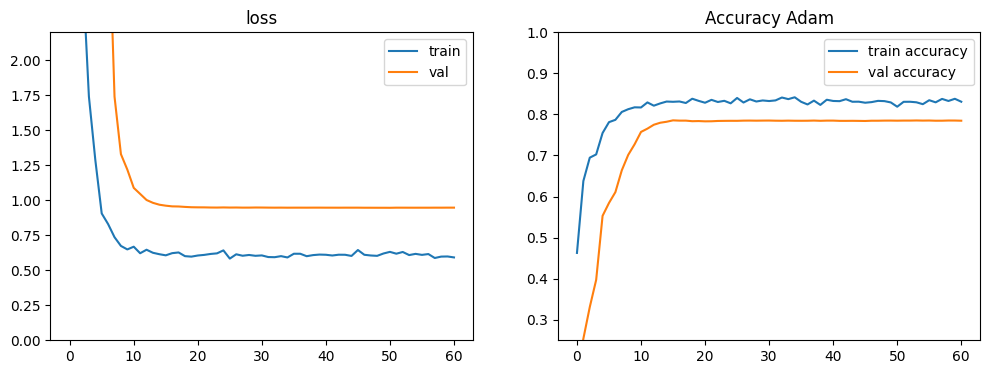

In [17]:
optimizer_str=str(K.eval(model.optimizer)).split(".")[-1].split()[0]

print("fit time with {} optimizer {} secs after {} epochs".format(optimizer_str, 
                                            (fit_end_time - fit_start_time), len(history.epoch)))

plot_history(history, optimizer_str)

In [21]:
import mlflow.keras

set_env_manual=True

if set_env_manual:
  os.environ['MODEL_TARGET'] = "mlflow"
  os.environ['MLFLOW_TRACKING_URI'] = "https://mlflow.lewagon.ai"
  os.environ['MLFLOW_EXPERIMENT'] = "ut_ds_prepro_ak"
  os.environ['MLFLOW_MODEL_NAME'] = id_str + "_" + optimizer_str
  os.environ['MLFLOW_STAGE'] = "staging"   

model_taget=os.environ.get("MODEL_TARGET")

if model_taget is None : model_taget=""

params = dict( sampling=sampling,
               win_len=win_len,
               overlap=overlap,
               overlap_len=overlap_len,
               
               model_type=mtype,
               optimizer=optimizer_str, 
               batch_size=batch_size,
               learning_rate=init_learning_rate,
               use_expo_decay=use_expo_decay,
               use_early_stop=use_early_stop)

metrics = dict(loss=loss, precision=precision, recall=recall, prc=prc )

if model_taget == "local" : 
   if save_model : 
      model.save("model_"+id_str)  
      print("model saved locally in {} dir".format(model_complexity))
   else:
      print("model is not saved")
elif model_taget == "mlflow" :
   try:
        print("save model to mlflow...")

        mlflow_tracking_uri = os.environ.get("MLFLOW_TRACKING_URI")
        mlflow_experiment = os.environ.get("MLFLOW_EXPERIMENT")
        mlflow_model_name = os.environ.get("MLFLOW_MODEL_NAME")
        
        if mlflow_tracking_uri != "" and mlflow_experiment != "" and mlflow_model_name != "" :
            mlflow.set_tracking_uri(mlflow_tracking_uri)
            mlflow.set_experiment(experiment_name=mlflow_experiment)

            with mlflow.start_run():                       
              if params is not None:
                  mlflow.log_params(params)

              if metrics is not None:
                  mlflow.log_metrics(metrics)

              if model is not None:
                  mlflow.keras.log_model(model, artifact_path="model",
                                         registered_model_name=mlflow_model_name)

            print("data saved to mlflow {} {} {} ok".format(mlflow_tracking_uri, mlflow_experiment, mlflow_model_name))
        else:
            print("mlflow env vars are missing or undefined...")
   except Exception as err:      
     print("error {} while saving model to mlflow".format(str(err)))

save model to mlflow...


INFO:tensorflow:Assets written to: /tmp/tmpoaauk3p6/model/data/model/assets


INFO:tensorflow:Assets written to: /tmp/tmpoaauk3p6/model/data/model/assets
Successfully registered model '6sensors_win20_with_overlap_Adam'.
2022/12/04 19:35:40 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: 6sensors_win20_with_overlap_Adam, version 1


data saved to mlflow https://mlflow.lewagon.ai ut_ds_prepro_ak 6sensors_win20_with_overlap_Adam ok


Created version '1' of model '6sensors_win20_with_overlap_Adam'.
